In [1]:
# importing libraries
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from pandas import ExcelWriter
from scipy import stats
from scipy.stats import norm, skew

# number of rows and columns to show
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

# ensuring graphs properly display 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability


# Raw Data -----------------------------------------------

# Financial Statements

In [2]:
# files
path = os.getcwd()
files = os.listdir(path)
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
#files_xlsx

['1000178728.xlsx',
 '1012419102.xlsx',
 '1016855147.xlsx',
 '1021379840.xlsx',
 '1022212263.xlsx',
 '102245282.xlsx',
 '1024358456.xlsx',
 '1034122568.xlsx',
 '1038040401.xlsx',
 '1053650554.xlsx',
 '1056288434.xlsx',
 '1057472399.xlsx',
 '106274216.xlsx',
 '1073288421.xlsx',
 '1086852673.xlsx',
 '1088950874.xlsx',
 '1096149325.xlsx',
 '1098658944.xlsx',
 '1104928517.xlsx',
 '1108281126.xlsx',
 '1117707358.xlsx',
 '1119146637.xlsx',
 '112025577.xlsx',
 '1124321639.xlsx',
 '1130735664.xlsx',
 '1133885491.xlsx',
 '1145755379.xlsx',
 '1152268155.xlsx',
 '1192711670.xlsx',
 '1201426678.xlsx',
 '1207001780.xlsx',
 '1207461427.xlsx',
 '1208049336.xlsx',
 '121531844.xlsx',
 '1217543490.xlsx',
 '123002698.xlsx',
 '1235624617.xlsx',
 '1249633870.xlsx',
 '1249655342.xlsx',
 '1251308305.xlsx',
 '1251472684.xlsx',
 '1261171166.xlsx',
 '1267149544.xlsx',
 '1267213959.xlsx',
 '1267589494.xlsx',
 '1267678889.xlsx',
 '1269827610.xlsx',
 '1281073706.xlsx',
 '1287956734.xlsx',
 '1298366105.xlsx',
 '129

In [3]:
# features
features_inc = ['Company_name','Year','Period End Date','Net Income','Normalized EBIT','Normalized EBITDA',
                'Diluted EPS Including ExtraOrd Items','Cost of Revenue, Total','Gross Profit','Total Revenue',
                'Selling/General/Admin. Expenses, Total','Total Operating Expense','Basic Normalized EPS']

features_bs = ['Company_name','Year','Period End Date','Accounts Receivable - Trade, Net','Total Inventory',
               'Property/Plant/Equipment, Total - Gross','Accounts Payable','Full-Time Employees',
               'Cash and Short Term Investments']

features_cf = ['Company_name','Year','Period End Date','Free Cash Flow',
               'Changes in Working Capital','Cash from Operating Activities','Capital Expenditures']

features_ratio = ['Company_name','Year','Asset Turnover','ROE','Quick Ratio','Current Ratio','Cash Cycle (Days)',
                  'A/R Turnover','Avg. A/R Days','Inv Turnover','Avg. Inventory Days','Avg. A/P Days',
                  'WC / Sales Growth','Debt/Equity','Gross Margin']

In [4]:
# dataframe
bs_sum = pd.DataFrame()
inc_sum = pd.DataFrame()
cf_sum = pd.DataFrame()
ratio_sum = pd.DataFrame()

In [5]:
# all FS
for f in files_xlsx:
    fs = pd.read_excel(f)
    name = fs.columns.values[0].split(" | ")[0]
    state = fs.columns.values[0].split(" | ")[1]
    
    if state == 'Income Statement':
        inc = fs.T
        inc = inc.rename(columns=inc.iloc[0]).drop(inc.index[:2]).reset_index(drop=True)
        inc.insert(0, 'Company_name', name)
        inc.columns.values[4] = "Year"
        inc_clean = inc[features_inc]
        inc_sum = inc_sum.append(inc_clean)
    elif state == 'Balance Sheet':
        bs = fs.T
        bs = bs.rename(columns=bs.iloc[0]).drop(bs.index[0]).reset_index(drop=True)
        bs.insert(0, 'Company_name', name)
        bs.columns.values[4] = "Year"
        bs_clean = bs[features_bs]
        bs_sum = bs_sum.append(bs_clean)  
    elif state == 'Cash Flow':
        cf = fs.T
        cf = cf.rename(columns=cf.iloc[0]).drop(cf.index[:2]).reset_index(drop=True)
        cf.insert(0, 'Company_name', name)
        cf.columns.values[4] = "Year" 
        cf_clean = cf[features_cf]
        cf_sum = cf_sum.append(cf_clean) 
    elif state == 'Ratios - Key Metrics':
        ratio = fs.T
        ratio = ratio.rename(columns=ratio.iloc[0]).drop(ratio.index[:2]).reset_index(drop=True)
        ratio.insert(0, 'Company_name', name)
        ratio.columns.values[4] = "Year" 
        ratio_clean = ratio[features_ratio]
        ratio_sum = ratio_sum.append(ratio_clean)        

In [7]:
# check shape
bs_sum.shape

(1128, 9)

In [8]:
inc_sum.shape

(1101, 13)

In [9]:
cf_sum.shape

(1045, 7)

In [10]:
ratio_sum.shape

(1126, 15)

In [100]:
# merge
fs_sum = pd.merge(pd.merge(inc_sum,bs_sum,how='left',on=['Company_name','Year','Period End Date']),
         cf_sum,sort=True,how='left', on=['Company_name','Year','Period End Date'])

In [101]:
# check shape
fs_sum.shape

(1101, 23)

In [102]:
# check comp number
len(fs_sum.Company_name.unique())

82

# Ratios

In [116]:
df = pd.merge(fs_sum,ratio_sum,sort=True,how='left',on=['Company_name','Year'])

In [117]:
df['Timestamp'] = pd.to_datetime(df['Period End Date'], errors='raise')

In [118]:
df.insert(2, 'Month', df.Timestamp.dt.month)
df.insert(3, 'Quarter', df.Timestamp.dt.quarter)

In [119]:
df.shape

(1101, 39)

In [120]:
df.head(3)

Company_name  Year  Month  Quarter Period End Date  Net Income  \
0  7digital Group plc  2000      3        1    31-Mar-2000        0.060   
1  7digital Group plc  2001      3        1    31-Mar-2001       -3.830   
2  7digital Group plc  2002      3        1    31-Mar-2002       -2.810   

   Normalized EBIT Normalized EBITDA  Diluted EPS Including ExtraOrd Items  \
0            0.130              0.26                                 0.010   
1           -1.180              -0.8                                -0.320   
2           -1.490             -0.77                                -0.220   

  Cost of Revenue, Total Gross Profit  Total Revenue  \
0                   2.97         1.27          4.240   
1                   4.46         1.72          6.180   
2                    6.2         2.99          9.190   

  Selling/General/Admin. Expenses, Total  Total Operating Expense  \
0                                   1.12                    4.140   
1                                   2.48                   10.510   
2                                    3.2                   12.220   

   Basic Normalized EPS Accounts Receivable - Trade, Net Total Inventory  \
0                 0.010                             0.84            0.05   
1                -0.170                             0.81            0.06   
2                -0.150                             0.82            0.05   

  Property/Plant/Equipment, Total - Gross Accounts Payable  \
0                                    1.16             0.53   
1                                    1.55             0.32   
2                                    1.64             0.36   

  Full-Time Employees Cash and Short Term Investments  Free Cash Flow  \
0                  42                            0.05          -0.090   
1                  62                            2.37          -1.430   
2                  69                            1.17          -0.440   

   Changes in Working Capital  Cash from Operating Activities  \
0                      -0.010                           0.240   
1                       0.270                          -0.290   
2                       0.360                          -0.290   

  Capital Expenditures Asset Turnover     ROE Quick Ratio Current Ratio  \
0                -0.33              -       -        0.86           0.9   
1                -1.13           1.95  -2.194         2.8          2.85   
2                -0.15           1.92  -1.634        1.66          1.68   

  Cash Cycle (Days) A/R Turnover Avg. A/R Days Inv Turnover  \
0                 -            -             -            -   
1              27.7          6.3          58.2         83.3   
2              39.2          6.5            56        108.7   

  Avg. Inventory Days Avg. A/P Days WC / Sales Growth Debt/Equity  \
0                   -             -                 -        0.34   
1                 4.4          34.9                 -        0.04   
2                 3.4          20.1             0.022        5.28   

  Gross Margin  Timestamp  
0        0.299 2000-03-31  
1        0.278 2001-03-31  
2        0.325 2002-03-31

In [123]:
df.to_csv('Output/all_fs_ratio.csv', index=False, encoding='utf-8')

In [124]:
writer = ExcelWriter('Output/all_fs_ratio.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

# Macro 

In [30]:
# files
path_macro = os.getcwd()
files = os.listdir(path_macro)
files_macro = [m for m in files if m[-7:] == 'uk.xlsx']
files_macro

['Consumer_confidence_uk.xlsx',
 'Consumer_spending_uk.xlsx',
 'CPI_uk.xlsx',
 'Employment_rate_uk.xlsx',
 'GDP_uk.xlsx',
 'Retail_sales_value_uk.xlsx']

In [32]:
files_macro[0].split('.')[0]

'Consumer_confidence_uk'

In [33]:
# GDP
gdp = pd.read_excel('GDP_uk.xlsx')

In [34]:
gdp = gdp.rename(columns=gdp.iloc[0]).drop(gdp.index[:8]).reset_index(drop=True)

In [35]:
gdp.drop(gdp.columns[[2]], axis=1, inplace=True)

In [36]:
gdp.columns.values[1].split(",")[0]

'United Kingdom GDP'

In [38]:
gdp.rename(columns={'Indicator': 'Date', 
                   'United Kingdom GDP, % year on year, Standardized, SA, Chg Y/Y': 'GDP_%'}, inplace=True)

In [39]:
gdp['Date'] = pd.to_datetime(gdp['Date'], errors='raise')

In [40]:
gdp["Year"] = gdp.Date.dt.year
gdp["Month"] = gdp.Date.dt.month
gdp["Quarter"] = gdp.Date.dt.quarter

In [41]:
gdp.head(3)

Date    GDP_%  Year  Month  Quarter
0 2017-03-31  1.98796  2017      3        1
1 2016-12-31  1.92907  2016     12        4
2 2016-09-30  1.95897  2016      9        3

In [54]:
# all macro 
m = 5
ma = pd.read_excel(files_macro[m])
ma = ma.rename(columns=ma.iloc[0]).drop(ma.index[:8]).reset_index(drop=True)
ma.drop(ma.columns[[2]], axis=1, inplace=True)
name = ma.columns.values[1].split(",")[0]
ma.columns = ['Date',name]
ma['Date'] = pd.to_datetime(ma['Date'], errors='raise')
ma["Year"] = ma.Date.dt.year
ma["Month"] = ma.Date.dt.month
ma["Quarter"] = ma.Date.dt.quarter

In [55]:
#macro_sum = pd.DataFrame()
#macro_sum = pd.merge(gdp,ma,on=['Year','Month','Date','Quarter'])
macro_sum = pd.merge(macro_sum,ma,on=['Year','Month','Date','Quarter'])

In [56]:
macro_sum.head(3)

Date    GDP_%  Year  Month  Quarter United Kingdom EC Consumer Survey  \
0 2017-03-31  1.98796  2017      3        1                              -4.3   
1 2016-12-31  1.92907  2016     12        4                              -4.6   
2 2016-09-30  1.95897  2016      9        3                              -1.7   

  United Kingdom Consumer Spending United Kingdom Core CPI  \
0                          2.55938                 1.82388   
1                          2.91294                 1.60903   
2                          2.61437                 1.49205   

  United Kingdom Employment United Kingdom Domestic Trade n.i.e.  
0                   1.34718                             -1.00724  
1                   1.50769                              1.03661  
2                    1.3946                             0.393386

In [58]:
macro_sum_1 = macro_sum

In [60]:
macro_sum_1.columns = ['Date', 'GDP', 'Year', 'Month', 'Quarter', 'Consumer_confidence', 'Consumer_spending',
                     'CPI', 'Employment_rate', 'Retail_sales']

In [61]:
macro_sum_1.head()

Date      GDP  Year  Month  Quarter Consumer_confidence  \
0 2017-03-31  1.98796  2017      3        1                -4.3   
1 2016-12-31  1.92907  2016     12        4                -4.6   
2 2016-09-30  1.95897  2016      9        3                -1.7   
3 2016-06-30  1.72764  2016      6        2                -1.2   
4 2016-03-31  1.60584  2016      3        1                   1   

  Consumer_spending      CPI Employment_rate Retail_sales  
0           2.55938  1.82388         1.34718     -1.00724  
1           2.91294  1.60903         1.50769      1.03661  
2           2.61437  1.49205          1.3946     0.393386  
3           2.87813  1.33576         1.92455    -0.544839  
4           2.62382  1.54646         1.63837    -0.706421

In [62]:
macro_sum_1.shape

(81, 10)

In [63]:
macro_sum_1.to_csv('Output/all_macro.csv', index=False, encoding='utf-8')

In [251]:
writer = ExcelWriter('Output/all_macro.xlsx')
macro_sum.to_excel(writer,'Sheet1')
writer.save()

# Retail index

In [64]:
# files
path_macro = os.getcwd()
files = os.listdir(path_macro)
files_retail = [m for m in files if m[-11:] == 'retail.xlsx']
files_retail

['Household goods stores_retail.xlsx',
 'Non-specialised stores_retail.xlsx',
 'Non-store retailing_retail.xlsx',
 'Other store_retail.xlsx',
 'Predominantly food stores_retail.xlsx',
 'Textile, clothing and footwear stores_retail.xlsx']

In [190]:
# household
house = pd.read_excel('Household goods stores_retail.xlsx')
house = house.rename(columns=house.iloc[0]).drop(house.index[:8]).reset_index(drop=True)
house.drop(house.columns[[2]], axis=1, inplace=True)
name = files_retail[0].split('_')[0]
house.columns = ['Date',name]
house['Date'] = pd.to_datetime(house['Date'], errors='raise')
house["Year"] = house.Date.dt.year
house["Month"] = house.Date.dt.month
house["Quarter"] = house.Date.dt.quarter

In [203]:
# all
r = 5
rt = pd.read_excel(files_retail[r])
rt = rt.rename(columns=rt.iloc[0]).drop(rt.index[:8]).reset_index(drop=True)
rt.drop(rt.columns[[2]], axis=1, inplace=True)
name = files_retail[r].split('_')[0]
rt.columns = ['Date',name]
rt['Date'] = pd.to_datetime(rt['Date'], errors='raise')
rt["Year"] = rt.Date.dt.year
rt["Month"] = rt.Date.dt.month
rt["Quarter"] = rt.Date.dt.quarter

In [204]:
#retail_sum = pd.DataFrame()
#retail_sum = pd.merge(house,rt,on=['Year','Month','Date','Quarter'])
retail_sum = pd.merge(retail_sum,rt,on=['Year','Month','Date','Quarter'])

In [207]:
retail_sum

Date Household goods stores  Year  Month  Quarter  \
0   2017-06-30                  117.9  2017      6        2   
1   2017-05-31                  114.2  2017      5        2   
2   2017-04-30                  121.1  2017      4        2   
3   2017-03-31                  117.8  2017      3        1   
4   2017-02-28                  117.8  2017      2        1   
5   2017-01-31                  114.4  2017      1        1   
6   2016-12-31                  115.8  2016     12        4   
7   2016-11-30                  126.5  2016     11        4   
8   2016-10-31                  121.1  2016     10        4   
9   2016-09-30                  118.1  2016      9        3   
10  2016-08-31                  115.4  2016      8        3   
11  2016-07-31                  120.1  2016      7        3   
12  2016-06-30                  116.2  2016      6        2   
13  2016-05-31                  121.4  2016      5        2   
14  2016-04-30                  113.1  2016      4        2   
15  2016-03-31                  116.7  2016      3        1   
16  2016-02-29                  120.8  2016      2        1   
17  2016-01-31                  119.3  2016      1        1   
18  2015-12-31                  116.6  2015     12        4   
19  2015-11-30                    120  2015     11        4   
20  2015-10-31                    117  2015     10        4   
21  2015-09-30                  118.8  2015      9        3   
22  2015-08-31                  114.3  2015      8        3   
23  2015-07-31                  119.4  2015      7        3   
24  2015-06-30                  114.6  2015      6        2   
25  2015-05-31                  115.3  2015      5        2   
26  2015-04-30                  114.8  2015      4        2   
27  2015-03-31                  114.9  2015      3        1   
28  2015-02-28                  112.4  2015      2        1   
29  2015-01-31                  111.3  2015      1        1   
30  2014-12-31                  110.3  2014     12        4   
31  2014-11-30                  111.3  2014     11        4   
32  2014-10-31                  110.7  2014     10        4   
33  2014-09-30                    107  2014      9        3   
34  2014-08-31                  109.3  2014      8        3   
35  2014-07-31                  105.2  2014      7        3   
36  2014-06-30                  106.8  2014      6        2   
37  2014-05-31                  103.1  2014      5        2   
38  2014-04-30                  102.7  2014      4        2   
39  2014-03-31                  104.1  2014      3        1   
40  2014-02-28                  103.1  2014      2        1   
41  2014-01-31                  105.8  2014      1        1   
42  2013-12-31                  103.4  2013     12        4   
43  2013-11-30                     98  2013     11        4   
44  2013-10-31                   98.5  2013     10        4   
45  2013-09-30                  100.5  2013      9        3   
46  2013-08-31                     97  2013      8        3   
47  2013-07-31                  101.3  2013      7        3   
48  2013-06-30                  101.9  2013      6        2   
49  2013-05-31                  102.7  2013      5        2   
50  2013-04-30                   99.4  2013      4        2   
51  2013-03-31                   95.8  2013      3        1   
52  2013-02-28                  102.5  2013      2        1   
53  2013-01-31                   98.6  2013      1        1   
54  2012-12-31                  101.6  2012     12        4   
55  2012-11-30                  103.6  2012     11        4   
56  2012-10-31                  100.2  2012     10        4   
57  2012-09-30                  100.7  2012      9        3   
58  2012-08-31                    101  2012      8        3   
59  2012-07-31                  102.5  2012      7        3   
60  2012-06-30                  104.8  2012      6        2   
61  2012-05-31                    105  2012      5        2   
62  2012-04-30                  104.1  20

In [206]:
retail_sum.shape

(354, 10)

In [208]:
retail_sum.to_csv('Output/all_retail_index.csv', index=False, encoding='utf-8')

In [252]:
writer = ExcelWriter('Output/all_retail_index.xlsx')
retail_sum.to_excel(writer,'Sheet1')
writer.save()

# Merging Data

In [7]:
# import data
comp_info = pd.read_excel('Output/all_comp_info.xlsx')
macro_sum = pd.read_csv('Output/all_macro.csv')
fs_sum = pd.read_csv('Output/all_fs_ratio.csv')

In [8]:
macro_sum.drop(['Date','Month'], axis=1, inplace=True)

In [9]:
comp_info_sub = comp_info[['Company_name','Retail_group','Business_sector','Industry_group',
                           'Industry','Company_MarketCap (£m)','FY10']]

In [10]:
df_sum = pd.merge(fs_sum, macro_sum, how='left', on=['Year','Quarter'])

In [11]:
df_sum = pd.merge(df_sum, comp_info_sub, how='left', on=['Company_name'])

In [12]:
df_sum.shape

(1101, 51)

In [13]:
# drop wrong comp
df_sum.drop(df_sum.loc[df_sum['Company_name'] == 'Dairy Farm International Holdings Ltd'].index, inplace=True)

In [14]:
df_sum.shape

(1080, 51)

In [15]:
# retail index
retail_sum = pd.read_csv('Output/used/all_retail_index.csv')

In [16]:
retail_sum.rename(columns={'Other store': 'Other stores'}, inplace=True)

In [17]:
df_index = pd.DataFrame()

In [18]:
for f in range (6):
    a = df_sum['Retail_group'].unique()[f]
    df_subindex = df_sum.loc[df_sum['Retail_group']==a].merge(retail_sum[[a,'Year','Quarter','Month']],how='left',on=['Year','Quarter','Month'])
    df_subindex.rename(columns={a:'Retail_sales_index'}, inplace=True)
    df_index = df_index.append(df_subindex)        

In [19]:
df_index.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1080 entries, 0 to 248
Data columns (total 52 columns):
Company_name                               1080 non-null object
Year                                       1080 non-null int64
Month                                      1080 non-null int64
Quarter                                    1080 non-null int64
Period End Date                            1080 non-null object
Net Income                                 1080 non-null float64
Normalized EBIT                            1080 non-null float64
Normalized EBITDA                          1080 non-null object
Diluted EPS Including ExtraOrd Items       1080 non-null float64
Cost of Revenue, Total                     1080 non-null object
Gross Profit                               1080 non-null object
Total Revenue                              1080 non-null float64
Selling/General/Admin. Expenses, Total     1080 non-null object
Total Operating Expense                    1080 non-null floa

In [20]:
df_index.to_csv('Output/all_data.csv', index=False, encoding='utf-8')

In [21]:
writer = ExcelWriter('Output/all_data.xlsx')
df_index.to_excel(writer,'Sheet1')
writer.save()

## Cleaning

In [22]:
df1 = pd.read_csv('Output/all_data.csv')

In [23]:
# convert '--' to NaN
df1 = df1.replace('--', '')

In [24]:
df1 = df1.replace('-', '')

In [25]:
df1 = df1.replace('', np.nan) #, regex=True)

In [27]:
df1.to_csv('Output/all_data.csv', index=False, encoding='utf-8')

In [28]:
writer = ExcelWriter('Output/all_data.xlsx')
df1.to_excel(writer,'Sheet1')
writer.save()

# Data Pre-processing and EDA ----------------------------

In [51]:
df1 = pd.read_csv('Output/all_data.csv')

In [40]:
# edit column names
# rename items from differ statements
df1.columns = ['Company_name', 'Year', 'Month', 'Quarter', 'Report_Date',
       'Net Income', 'Normalized EBIT', 'Normalized EBITDA',
       'Diluted EPS', 'Cost of Revenue','Gross Profit', 'Total Revenue',
       'SGA Expenses', 'Total Operating Expense',
       'Normalized EPS', 'Accounts Receivable','Total Inventory', 'PPE',
       'Accounts Payable', 'Full-Time Employees','Cash and ST Invest', 'FCF',
       'Changes in WC', 'Cash from OA','Capital Expenditures', 
       'Asset Turnover', 'ROE', 'Quick Ratio',
       'Current Ratio', 'Cash Cycle(Days)', 'A/R Turnover', 'Avg. A/R Days',
       'Inv Turnover', 'Avg. Inventory Days', 'Avg. A/P Days',
       'WC/Sales Growth', 'Debt/Equity', 'Gross Margin', 
       'Timestamp', 'GDP','Consumer_confidence', 'Consumer_spending', 
       'CPI', 'Employment_rate','Retail_sales', 
       'Retail_group', 'Business_sector', 'Industry_group','Industry', 
       'Company_MarketCap', 'FY10', 'Retail_sales_index']

In [41]:
# initial inspection
#df1.head(3)
#df1.columns.sort_values()
#df1.shape
df1.info()
#df1.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 52 columns):
Company_name               1080 non-null object
Year                       1080 non-null int64
Month                      1080 non-null int64
Quarter                    1080 non-null int64
Report_Date                1080 non-null object
Net Income                 1080 non-null float64
Normalized EBIT            1080 non-null float64
Normalized EBITDA          1076 non-null float64
Diluted EPS                1080 non-null float64
Cost of Revenue            1071 non-null float64
Gross Profit               1071 non-null float64
Total Revenue              1080 non-null float64
SGA Expenses               1010 non-null float64
Total Operating Expense    1080 non-null float64
Normalized EPS             1080 non-null float64
Accounts Receivable        1057 non-null float64
Total Inventory            1067 non-null float64
PPE                        1030 non-null float64
Accounts Payable   

In [42]:
df1.describe()

Year    Month  Quarter  Net Income  Normalized EBIT  \
count 1080.000 1080.000 1080.000    1080.000         1080.000   
mean  2008.114    5.381    2.051      73.284          146.811   
std      6.168    4.099    1.249     300.453          425.161   
min   1993.000    1.000    1.000   -5741.000        -1687.800   
25%   2004.000    2.000    1.000       1.400            4.630   
50%   2009.000    3.000    1.000      12.050           23.250   
75%   2013.000    9.000    3.000      52.175           87.050   
max   2017.000   12.000    4.000    2806.000         5027.000   

       Normalized EBITDA  Diluted EPS  Cost of Revenue  Gross Profit  \
count           1076.000     1080.000         1071.000      1071.000   
mean             208.413       76.817         2114.907       439.569   
std              571.080     2522.289         6446.015       854.092   
min            -1676.600      -36.700            0.000      -235.000   
25%                7.560        0.010           60.885        35.000   
50%               36.000        0.070          199.300       113.900   
75%              118.250        0.210         1039.850       399.150   
max             5593.000    82890.910        59091.000      6785.000   

       Total Revenue  SGA Expenses  Total Operating Expense  Normalized EPS  \
count       1080.000      1010.000                 1080.000        1080.000   
mean        2535.632       275.686                 2414.941          76.861   
std         6986.208       528.806                 6728.196        2522.287   
min           -2.820         0.000                 -753.000         -36.700   
25%          119.525        23.575                  106.200           0.020   
50%          355.200        84.000                  324.300           0.080   
75%         1427.100       275.400                 1393.000           0.230   
max        63916.000      3445.000                62675.000       82890.910   

       Accounts Receivable  Total Inventory       PPE  Accounts Payable  \
count             1057.000         1067.000  1030.000          1065.000   
mean                79.574          201.526  1306.701           249.855   
std                232.011          429.380  4164.932           706.523   
min                  0.000            0.000     0.000             0.000   
25%                  1.820            8.900    31.192             9.900   
50%                  9.900           37.800   110.300            31.600   
75%                 48.600          159.750   395.900           131.900   
max               2482.900         3744.000 36791.000          7359.000   

       Full-Time Employees  Cash and ST Invest       FCF  Changes in WC  \
count             1024.000            1064.000  1025.000       1025.000   
mean             17667.564             130.359    28.240        -41.212   
std              54059.833             480.003   158.824        127.913   
min                  3.000               0.000 -1843.000      -1752.000   
25%                823.250               3.700    -1.860        -27.500   
50%               3016.000              16.495     4.390         -5.250   
75%              10945.250              64.775    30.200         -0.110   
max             519671.000            6832.000  1727.000        262.000   

       Cash from OA  Capital Expenditures  Asset Turnover     ROE  \
count      1025.000              1019.000         974.000 933.000   
mean        150.336              -122.815           1.932   0.208   
std         426.393               398.306           1.102   1.625   
min       -1044.400             -4707.000          -0.020 -20.400   
25%           3.880               -47.450           1.300   0.058   
50%          22.700               -13.010           1.800   0.157   
75%          84.800                -3.420           2.397   0.261   
max        4745.000                 0.000          14.730  36.367   

       Quick Ratio  Current Ratio  Cash Cycle(Days)  A/R Turnover  \
count     1062.000  

In [43]:
# check the range of model by year
print ("The range of the model is between ", df1['Year'].min(), " ~ ", df1['Year'].max())

The range of the model is between  1993  ~  2017


## Abnormal trends

In [44]:
len(df1.Company_name.unique())

81

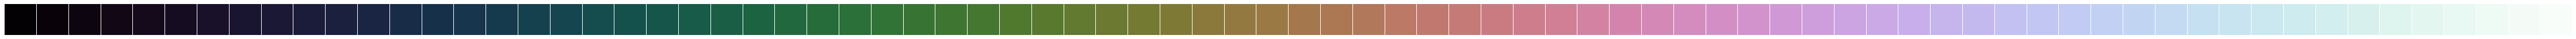

In [315]:
# sns color, style, title, axis
#color = sns.color_palette()
sns.palplot(sns.color_palette("cubehelix", 80))
sns.set_style('ticks')

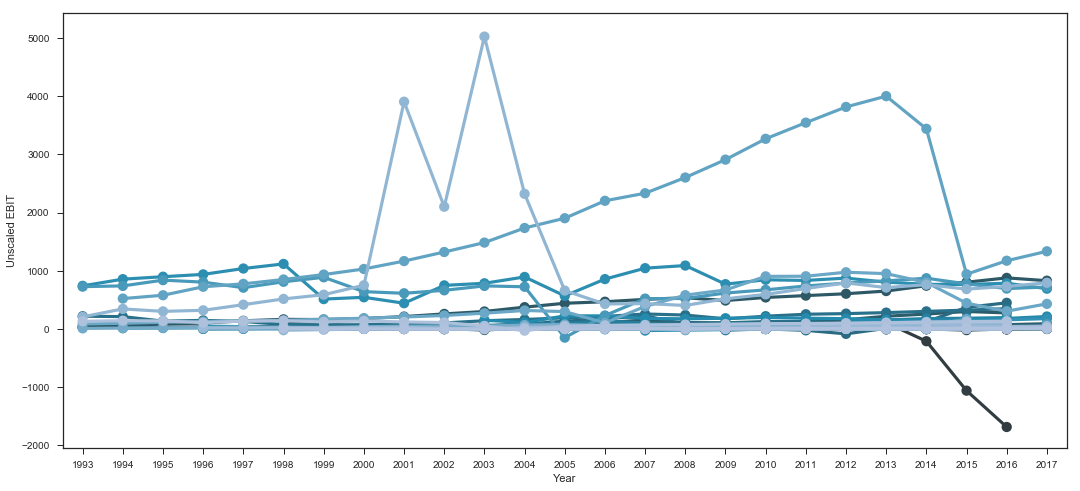

In [72]:
# all trends
plt.figure(figsize=(18,8))
ax = sns.pointplot('Year', 'Normalized EBIT', data=df1, fit_reg=False, hue='Company_name',palette="PuBuGn_d")
ax.set(xlabel='Year', ylabel='Unscaled EBIT')
ax.legend_.remove()
plt.show()

In [93]:
df1.Industry.unique()

array(['Broadasting', 'Online Services',
       'Apparel and Accessories Retailers',
       'Miscellaneous Specialty Retailers',
       'Oil and Gas Refining and Marketing',
       'Healthcare Facilities and services',
       'Auto Vehicles Parts and Service Retailers',
       'Computer and Electronics Retailers',
       'Electrical Components and Equipment', 'Business Support Services',
       'Non-Gold Precious Metals and Minerals',
       'Construction Supplies and Fixtures',
       'Property & Casualty Insurance', 'Discount Stores',
       'Department Stores', 'Food Retail and Distribution',
       'Restaurants & Bars', 'Food processing', 'Fishing and Farming',
       'Home Furnishings Retailers', 'Personal services',
       'Home Improvement Products & Services Retailers',
       'Industrial Machinery and Equipment'], dtype=object)

[<matplotlib.text.Text at 0x12e86beb8>, <matplotlib.text.Text at 0x12e88c908>]

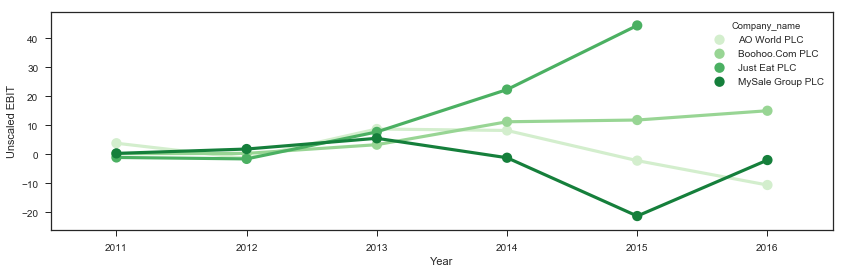

In [372]:
# by industry
Industry = 'Online Services'
dfins = df1.loc[df1['Industry']== Industry ]
plt.figure(figsize=(14,4))
ax = sns.pointplot('Year', 'Normalized EBIT', data=dfins, fit_reg=False, hue='Company_name',palette='Greens')
sns.plt.title(Industry)
ax.set(xlabel='Year', ylabel='Unscaled EBIT')

In [45]:
# abnormal trends - outliers
abnormal = ['Tesco PLC','Koovs PLC','Kingfisher PLC']

In [46]:
df_abnormal = df1.loc[df1['Company_name'].isin(abnormal)]

[<matplotlib.text.Text at 0x11b236470>, <matplotlib.text.Text at 0x1197c5780>]

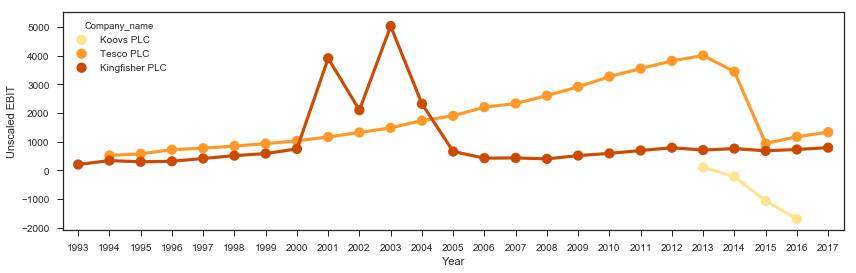

In [71]:
#df_abnormal = df1.loc[df.Company_name.isin(['Tesco PLC','Koovs PLC','Kingfisher PLC'])]
plt.figure(figsize=(14,4))
ax = sns.pointplot('Year', 'Normalized EBIT', data=df_abnormal, fit_reg=False, hue='Company_name',palette="YlOrBr")
sns.plt.title('Abnormal Trends')
ax.set(xlabel='Year', ylabel='Unscaled EBIT')

In [47]:
# exclude abnormal trends
# Tesco: http://www.bbc.co.uk/news/business-32408661
df1 = df1.drop(df1.loc[df1['Company_name'].isin(abnormal)].index).reset_index(drop=True)

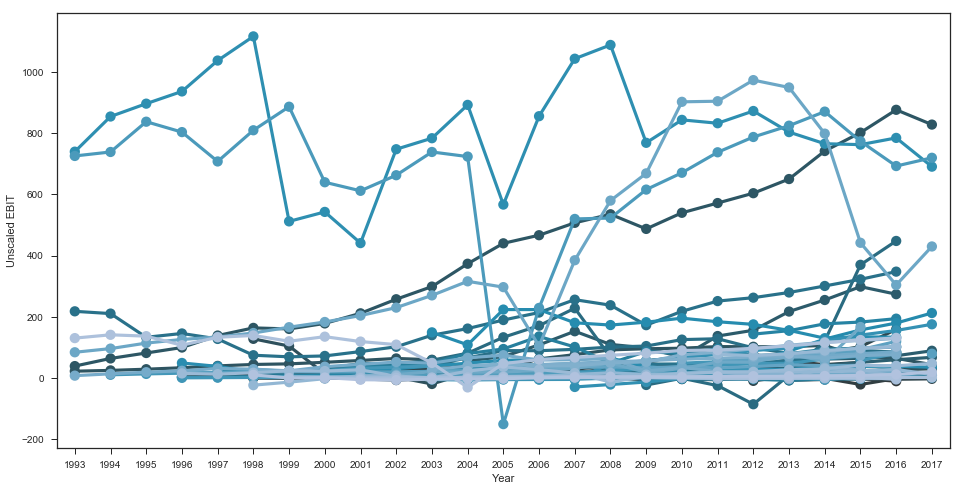

In [79]:
# other trends
plt.figure(figsize=(16,8))
ax = sns.pointplot('Year', 'Normalized EBIT', data=df1, fit_reg=False, hue='Company_name',palette="PuBuGn_d")
sns.plt.title('All')
ax.legend_.remove()
ax.set(xlabel='Year', ylabel='Unscaled EBIT')
#ax.set_ylim(-100, 450)
plt.show()

In [90]:
# supermarkets
spmarkets = ['Marks and Spencer Group PLC','J Sainsbury PLC','WM Morrison Supermarkets PLC']#,'Next PLC']

[<matplotlib.text.Text at 0x106997128>, <matplotlib.text.Text at 0x11c9f85c0>]

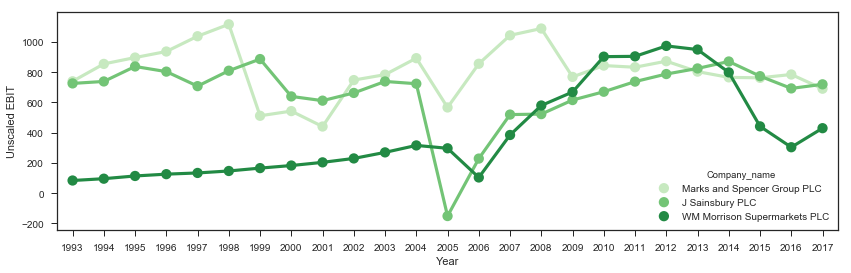

In [92]:
df_spm = df1.loc[df1['Company_name'].isin(spmarkets )]
plt.figure(figsize=(14,4))
ax = sns.pointplot('Year', 'Normalized EBIT', data=df_spm, fit_reg=False, hue='Company_name',palette='Greens')
sns.plt.title('Supermarkets')
ax.set(xlabel='Year', ylabel='Unscaled EBIT')

In [86]:
df2 = df1.drop(df1.loc[df1['Company_name'].isin(spmarkets)].index).reset_index(drop=True)

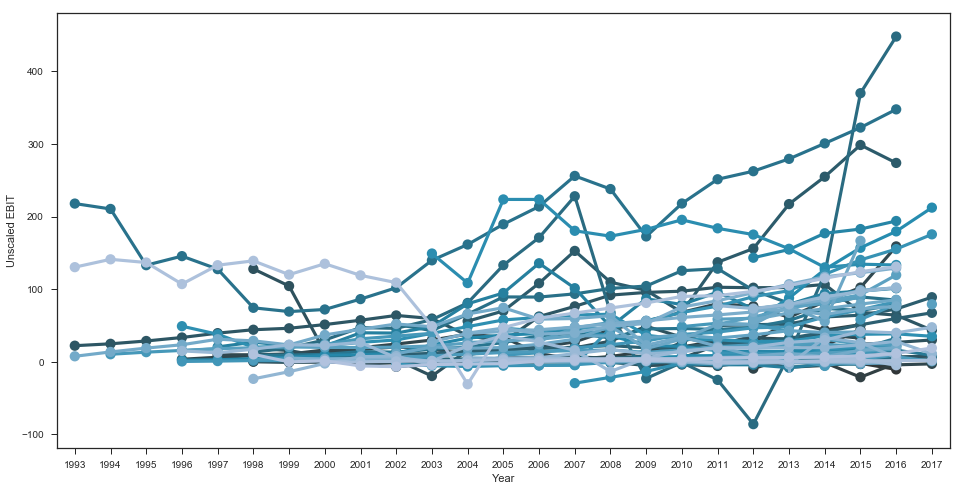

In [87]:
# other trends
plt.figure(figsize=(16,8))
ax = sns.pointplot('Year', 'Normalized EBIT', data=df2, fit_reg=False, hue='Company_name',palette="PuBuGn_d")
sns.plt.title('All')
ax.legend_.remove()
ax.set(xlabel='Year', ylabel='Unscaled EBIT')
#ax.set_ylim(-100, 450)
plt.show()

In [48]:
df1.to_csv('Output/all_data_ab.csv', index=False, encoding='utf-8')

In [49]:
writer = ExcelWriter('Output/all_data_ab.xlsx')
df1.to_excel(writer,'Sheet1')
writer.save()

## Missing values

In [71]:
df1 = pd.read_csv('Output/all_data_ab.csv')

In [73]:
sns.set_style('ticks')

In [74]:
# null values
null_columns=df1.columns[df1.isnull().any()]
df1[null_columns].isnull().sum().sort_values()

Normalized EBITDA         4
Current Ratio             8
Cost of Revenue           9
Gross Profit              9
Total Inventory          13
Accounts Payable         15
Cash and ST Invest       16
Quick Ratio              18
Accounts Receivable      19
Gross Margin             33
Retail_sales             47
CPI                      47
Consumer_spending        47
Consumer_confidence      47
Employment_rate          47
GDP                      47
PPE                      49
FCF                      52
Changes in WC            52
Cash from OA             52
Full-Time Employees      54
Capital Expenditures     58
Debt/Equity              64
SGA Expenses             66
Asset Turnover          102
A/R Turnover            102
Cash Cycle(Days)        104
Avg. A/R Days           104
Inv Turnover            116
Avg. Inventory Days     117
Avg. A/P Days           121
ROE                     143
WC/Sales Growth         203
dtype: int64

In [75]:
# percentage
all_data_na = df1.isnull().sum() / len(df1) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing%' :all_data_na})
missing_data

Missing%
WC/Sales Growth         19.766
ROE                     13.924
Avg. A/P Days           11.782
Avg. Inventory Days     11.392
Inv Turnover            11.295
Avg. A/R Days           10.127
Cash Cycle(Days)        10.127
A/R Turnover             9.932
Asset Turnover           9.932
SGA Expenses             6.426
Debt/Equity              6.232
Capital Expenditures     5.648
Full-Time Employees      5.258
Cash from OA             5.063
Changes in WC            5.063
FCF                      5.063
PPE                      4.771
GDP                      4.576
Employment_rate          4.576
Consumer_confidence      4.576
Consumer_spending        4.576
CPI                      4.576
Retail_sales             4.576
Gross Margin             3.213
Accounts Receivable      1.850
Quick Ratio              1.753
Cash and ST Invest       1.558
Accounts Payable         1.461
Total Inventory          1.266
Gross Profit             0.876

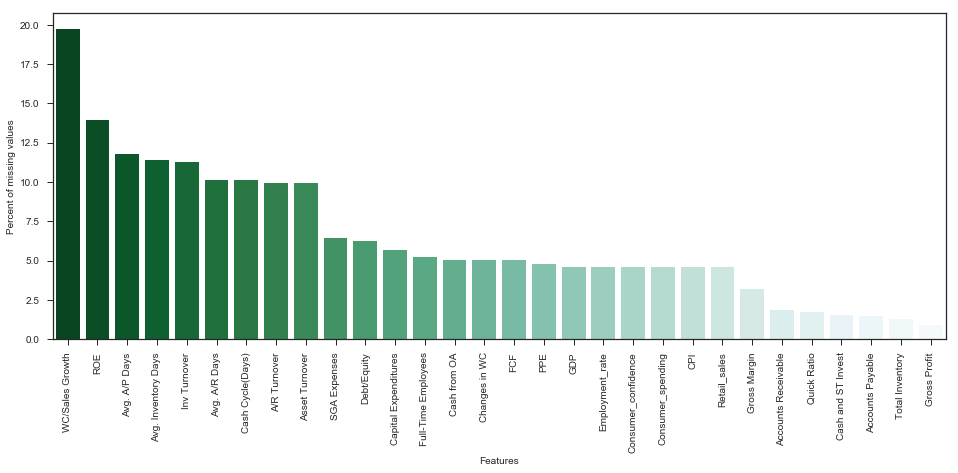

In [76]:
f, ax = plt.subplots(figsize=(16, 6))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na,palette='BuGn_r')
plt.xlabel('Features', fontsize=10)
plt.ylabel('Percent of missing values', fontsize=10)
#plt.title('Percent missing data by feature', fontsize=10)

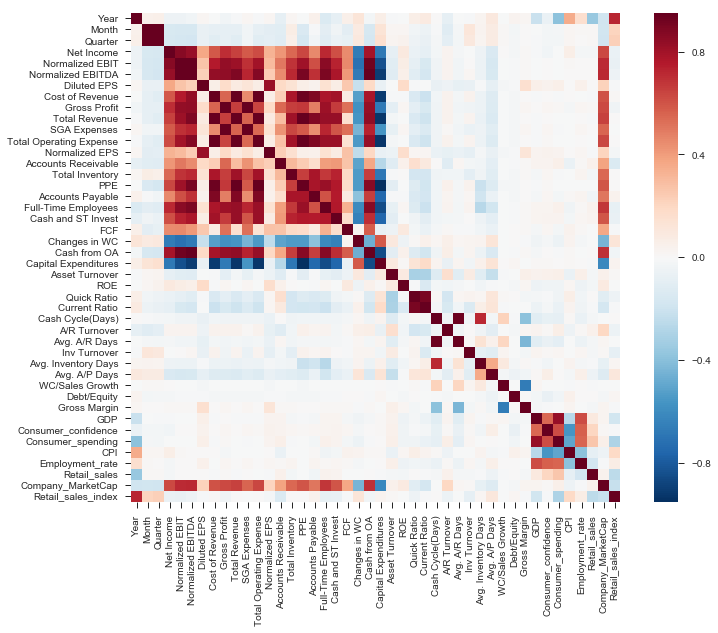

In [77]:
# correlation map to see how features are correlated with EBIT
corrmat = df1.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [78]:
# drop features won't help in predictive modelling
df1.drop(['WC/Sales Growth','ROE','Avg. A/P Days'], axis=1, inplace=True)

In [23]:
# drop early years
#df1 = df1.drop(df1.loc[df1['Year'] <= 1996].index).reset_index(drop=True)

In [ ]:
# drop specific columns
#df1 = df1.dropna(subset = ['GDP', 'Consumer_confidence'])

In [173]:
# inspecting rows
len(df1.index[df1.isnull().sum(axis=1) >= 6])

11

In [167]:
# fill ratios with median values
missing = ['Avg. Inventory Days','Inv Turnover','Avg. A/R Days','Cash Cycle(Days)','A/R Turnover','Asset Turnover',
          'Gross Margin','Current Ratio','Quick Ratio','Debt/Equity',
          'Retail_sales','CPI','Consumer_spending','Consumer_confidence','Employment_rate','GDP']

In [168]:
for features in missing:
    df1[features] = df1.groupby('Company_name')[features].transform(lambda x: x.fillna(x.median()))

In [174]:
# drop na
df1.dropna(inplace=True)

In [175]:
df1.shape

(831, 49)

In [176]:
df1.to_csv('Output/all_data_na.csv', index=False, encoding='utf-8')

In [177]:
writer = ExcelWriter('Output/all_data_na.xlsx')
df1.to_excel(writer,'Sheet1')
writer.save()

## Scaling (z-score normalization)
Method: 
- scale: http://scikit-learn.org/stable/modules/preprocessing.html
- standard: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- maxmin: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [79]:
df1 = pd.read_csv('Output/all_data_na.csv')

In [81]:
# normalize all numerical data
Numerical = np.array(df1._get_numeric_data().ix[:,3:44].values)
scaler_num = preprocessing.StandardScaler().fit(Numerical)
df1._get_numeric_data().ix[:,3:44] = scaler_num.transform(Numerical)    

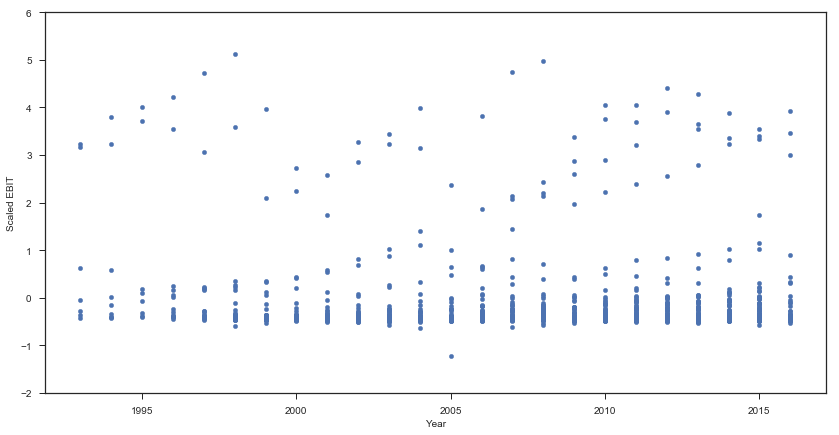

In [82]:
plt.rcParams["figure.figsize"] = [14,7]
df1.plot(x="Year", y="Normalized EBIT", kind="scatter", ylim=(-2, 6))
plt.xlabel('Year', fontsize=10)
plt.ylabel('Scaled EBIT', fontsize=10)

In [83]:
#standardizing data
low_range = df1['Normalized EBIT'][df1['Normalized EBIT'].argsort()][:10]
high_range= df1['Normalized EBIT'][df1['Normalized EBIT'].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
Normalized EBIT
538   -1.230
800   -0.629
446   -0.622
717   -0.592
447   -0.581
36    -0.580
130   -0.572
718   -0.542
710   -0.541
752   -0.541
Name: Normalized EBIT, dtype: float64

outer range (high) of the distribution:
Normalized EBIT
424   4.016
641   4.046
642   4.056
425   4.216
644   4.281
643   4.401
426   4.722
436   4.752
437   4.977
427   5.117
Name: Normalized EBIT, dtype: float64


In [191]:
#deleting points
df1.sort_values(by = 'Normalized EBIT', ascending = False)[:2]
#df1[(df1['Normalized EBIT'] <= -1) & (df1['Normalized EBIT'] >= 5)]['Normalized EBIT'].count()
#df1 = df1.drop(df1[df1['Normalized EBIT'] >= 5].index)

Company_name  Year  Month  Quarter   Report_Date  \
427  Marks and Spencer Group PLC  1998      3        1  31-Mar-1998    
437  Marks and Spencer Group PLC  2008      3        1  29-Mar-2008    

     Net Income  Normalized EBIT  Normalized EBITDA  Diluted EPS  \
427       5.478            5.117              4.060        0.250   
437       5.429            4.977              4.499        0.634   

     Cost of Revenue  Gross Profit  Total Revenue  SGA Expenses  \
427            1.255         4.368          1.852         3.074   
437            1.321         5.324          2.071         5.248   

     Total Operating Expense  Normalized EPS  Accounts Receivable  \
427                    1.631           0.169                6.834   
437                    1.830           0.463                0.075   

     Total Inventory   PPE  Accounts Payable  Full-Time Employees  \
427            1.668 1.820             0.191                3.230   
437            1.617 2.803             0.183                3.445   

     Cash and ST Invest    FCF  Changes in WC  Cash from OA  \
427               4.211 -0.977         -7.472         2.546   
437               1.562  0.178         -3.902         4.325   

     Capital Expenditures  Asset Turnover  Quick Ratio  Current Ratio  \
427                -3.786          -0.804        0.342         -0.015   
437                -5.259          -0.517       -0.540         -0.803   

     Cash Cycle(Days)  A/R Turnover  Avg. A/R Days  Inv Turnover  \
427             0.052        -0.464          0.050        -0.087   
437            -0.087         0.153         -0.083        -0.053   

     Avg. Inventory Days  Debt/Equity  Gross Margin   Timestamp   GDP  \
427               -0.647       -0.167         0.037  1998-03-31 0.865   
437               -0.682        0.011         0.041  2008-03-29 0.250   

     Consumer_confidence  Consumer_spending    CPI  Employment_rate  \
427                1.094              0.492 -0.114            0.865   
437               -0.253              0.245 -0.739           -0.122   

     Retail_sales            Retail_group Business_sector  \
427        -0.339  Non-specialised stores       Retailers   
437        -1.207  Non-specialised stores       Retailers   

          Industry_group                           Industry  \
427  Specialty Retailers  Miscellaneous Specialty Retailers   
437  Specialty Retailers  Miscellaneous Specialty Retailers   

     Company_MarketCap FY10  Retail_sales_index  
427              2.103    Y              -1.647  
437              2.103    Y              -0.370

## Transformation (Skewness)
Transform all the numerical features using the boxcox transformation to obtain less skewed features and less outliers

### Log transformation

In [84]:
df2 = df1.copy()

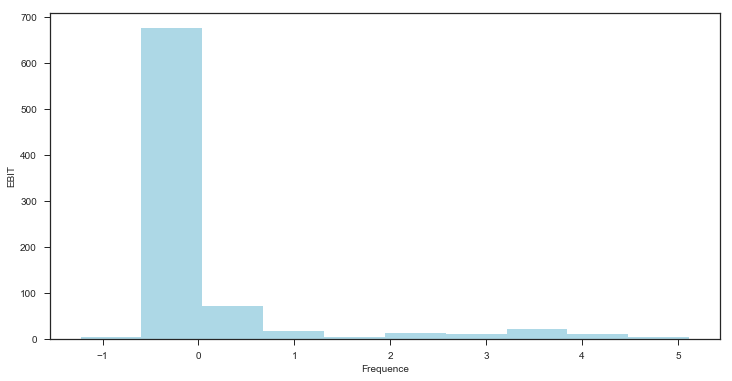

In [85]:
# EBIT
csfont = {'fontname':'Arial'}
plt.figure(figsize=(12,6))
n, bins, patches = plt.hist(df2['Normalized EBIT'],align='mid',color='lightblue')

plt.xlabel('Frequence', fontsize=10, **csfont)
plt.ylabel("EBIT", fontsize=10, **csfont)
plt.title("Histogram of EBIT", fontsize=10, **csfont)
plt.show()

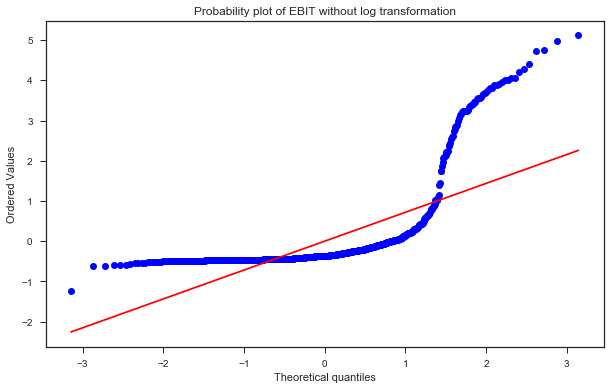

In [86]:
plt.rcParams["figure.figsize"] = [10,6]
res = stats.probplot(df2['Normalized EBIT'], plot=plt)
plt.title("Probability plot of EBIT without log transformation", fontsize=12, **csfont)

In [89]:
C = 1 - min(df2['Normalized EBIT'])
C

2.2296959164322043

In [90]:
# log EBIT (log1p)
# log percentage: http://fmwww.bc.edu/repec/bocode/t/transint.html
df2['Log_EBIT'] = np.log1p(df2['Normalized EBIT']+C)

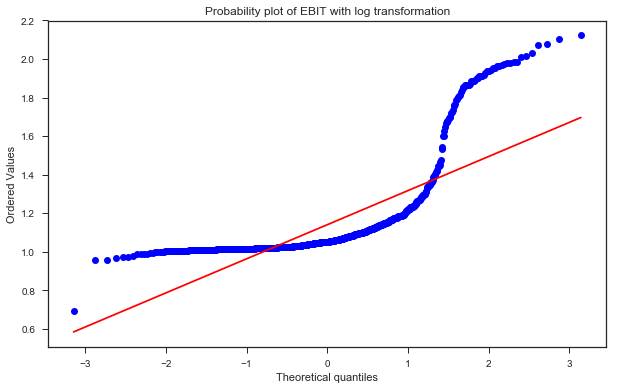

In [91]:
plt.rcParams["figure.figsize"] = [10,6]
res = stats.probplot(df2['Log_EBIT'], plot=plt)
plt.title("Probability plot of EBIT with log transformation", fontsize=12, **csfont)

### Box-cox

In [92]:
df2 = df1.copy()

In [93]:
# check the skew of all numerical features
#df1._get_numeric_data().ix[:,3:44]
numeric_feats = df2.dtypes[df2.dtypes != "object"].index
skewed_feats = df2[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

Skew
Avg. A/R Days            26.490
Cash Cycle(Days)         25.208
Debt/Equity              11.224
Inv Turnover              7.652
Accounts Receivable       7.220
Accounts Payable          6.680
Quick Ratio               5.976
A/R Turnover              5.335
Normalized EPS            5.106
Current Ratio             4.413
Cash and ST Invest        4.114
Cost of Revenue           4.092
PPE                       4.026
SGA Expenses              3.939
Asset Turnover            3.774
FCF                       3.761
Total Operating Expense   3.710
Gross Profit              3.660
Total Revenue             3.631
Cash from OA              3.389
Full-Time Employees       3.150
Normalized EBIT           3.056
Normalized EBITDA         3.039
Avg. Inventory Days       2.792
Net Income                2.603
Total Inventory           2.437
Diluted EPS               1.482
Company_MarketCap         1.417
Month                     0.643
Quarter                   0.624
CPI                       0.306
Retail_sales              0.293
Year                     -0.472
Employment_rate          -0.577
Consumer_confidence      -0.687
Retail_sales_index       -0.857
Consumer_spending        -1.304
GDP                      -2.600
Capital Expenditures     -3.938
Changes in WC            -4.369
Gross Margin            -28.308

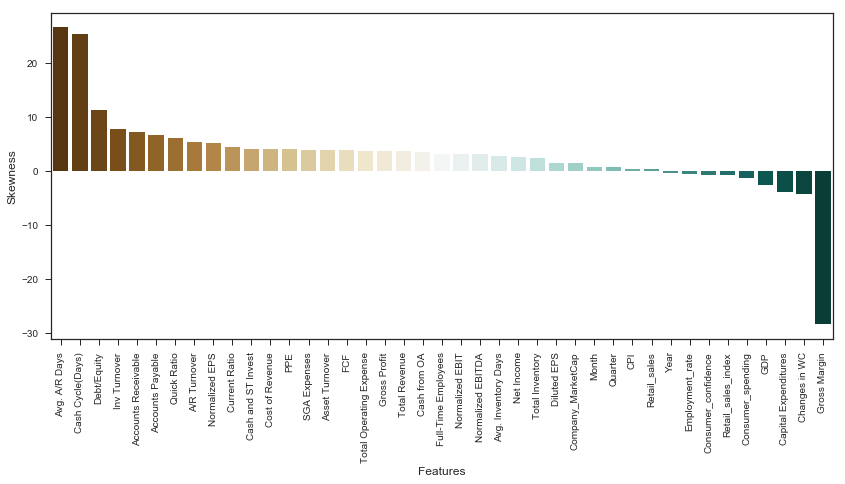

In [94]:
f, ax = plt.subplots(figsize=(14, 6))
plt.xticks(rotation='90')
sns.barplot(x=skewness.index, y=skewness['Skew'], palette='BrBG')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Skewness', fontsize=12)
plt.title('Percent missing data by feature', fontsize=10)

In [95]:
# boxcox
# ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html
from scipy.special import boxcox1p
from scipy import stats

skewness = skewness[abs(skewness) > 1]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
# set lam
lam = -1
for feat in skewed_features:
    #all_data[feat] += 1
    df2[feat] = boxcox1p(df2[feat], lam)
    #stats.boxcox(x, lmbda=None, alpha=None)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 41 skewed numerical features to Box Cox transform


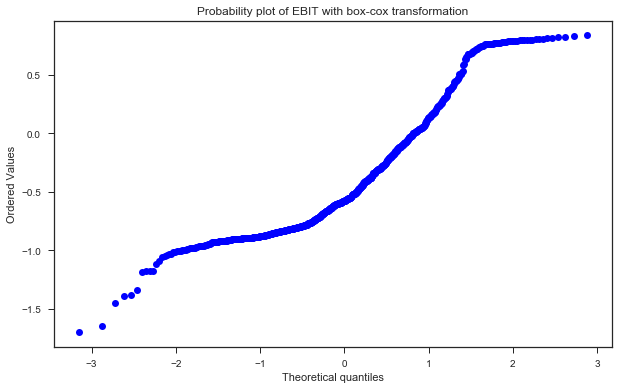

In [100]:
csfont = {'fontname':'Arial'}
plt.rcParams["figure.figsize"] = [10,6]
res = stats.probplot(df2['Normalized EBIT'], plot=plt)
plt.title("Probability plot of EBIT with box-cox transformation", fontsize=12, **csfont)

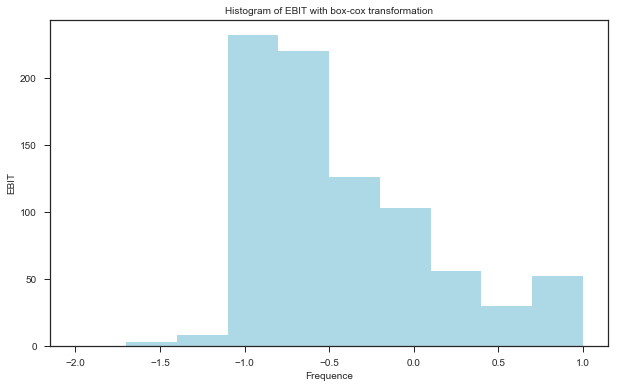

In [258]:
csfont = {'fontname':'Arial'}
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df2['Normalized EBIT'],10, range=[-2,1],align='mid',color='lightblue')

plt.xlabel('Frequence', fontsize=10, **csfont)
plt.ylabel("EBIT", fontsize=10, **csfont)

plt.title("Histogram of EBIT with box-cox transformation", fontsize=10, **csfont)
plt.show()

## EBIT t+1 (y variable)

In [267]:
df1.shape

(831, 49)

In [268]:
print (len(df1.Company_name.unique()))
print (len(df1.loc[df1['Year'] >= 2015].Company_name.unique()))

72
60


In [269]:
dfml = df1.copy()

In [270]:
# histroical data
dfml['EBIT'] = dfml['Normalized EBIT']
dfml['EBIT_t+1'] = dfml.groupby(['Company_name'])['Normalized EBIT'].transform(lambda x:x.shift(-1))
dfml['EBIT_t-1'] = dfml.groupby(['Company_name'])['Normalized EBIT'].transform(lambda x:x.shift(1))
#dfml['EBIT_t-2'] = dfml.groupby(['Company_name'])['Normalized EBIT'].transform(lambda x:x.shift(2))

In [271]:
dfml

Company_name  Year  Month  Quarter   Report_Date  \
0             7digital Group plc  2000      3        1  31-Mar-2000    
1             7digital Group plc  2001      3        1  31-Mar-2001    
2             7digital Group plc  2002      3        1  31-Mar-2002    
3             7digital Group plc  2003      3        1  31-Mar-2003    
4             7digital Group plc  2004      3        1  31-Mar-2004    
5             7digital Group plc  2005      3        1  31-Mar-2005    
6             7digital Group plc  2006      3        1  31-Mar-2006    
7             7digital Group plc  2007      3        1  31-Mar-2007    
8             7digital Group plc  2008      3        1  31-Mar-2008    
9             7digital Group plc  2009      3        1  31-Mar-2009    
10            7digital Group plc  2010      3        1  31-Mar-2010    
11            7digital Group plc  2011      3        1  31-Mar-2011    
12            7digital Group plc  2014     12        4  31-Dec-2014    
13            7digital Group plc  2014      3        1  31-Mar-2014    
14            7digital Group plc  2015     12        4  31-Dec-2015    
15                  AO World PLC  2011      3        1  31-Mar-2011    
16                  AO World PLC  2012      3        1  31-Mar-2012    
17                  AO World PLC  2013      3        1  31-Mar-2013    
18                  AO World PLC  2014      3        1  31-Mar-2014    
19                  AO World PLC  2015      3        1  31-Mar-2015    
20                  AO World PLC  2016      3        1  31-Mar-2016    
21                Boohoo.Com PLC  2011      2        1  28-Feb-2011    
22                Boohoo.Com PLC  2012      2        1  29-Feb-2012    
23                Boohoo.Com PLC  2013      2        1  28-Feb-2013    
24                Boohoo.Com PLC  2014      2        1  28-Feb-2014    
25                Boohoo.Com PLC  2015      2        1  28-Feb-2015    
26                Boohoo.Com PLC  2016      2        1  29-Feb-2016    
27                  Just Eat PLC  2011     12        4  31-Dec-2011    
28                  Just Eat PLC  2012     12        4  31-Dec-2012    
29                  Just Eat PLC  2013     12        4  31-Dec-2013    
30                  Just Eat PLC  2014     12        4  31-Dec-2014    
31                  Just Eat PLC  2015     12        4  31-Dec-2015    
32              MySale Group PLC  2011      6        2  30-Jun-2011    
33              MySale Group PLC  2012      6        2  30-Jun-2012    
34              MySale Group PLC  2013      6        2  30-Jun-2013    
35              MySale Group PLC  2014      6        2  30-Jun-2014    
36              MySale Group PLC  2015      6        2  30-Jun-2015    
37                      ASOS PLC  1998     12        4  31-Dec-1998    
38                      ASOS PLC  1999     12        4  31-Dec-1999    
39                      ASOS PLC  2000     12        4  31-Dec-2000    
40                      ASOS PLC  2001     12        4  31-Dec-2001    
41                      ASOS PLC  2002     12        4  31-Dec-2002    
42                      ASOS PLC  2004      3        1  31-Mar-2004    
43                      ASOS PLC  2005      3        1  31-Mar-2005    
44                      ASOS PLC  2006      3        1  31-Mar-2006    
45                      ASOS PLC  2007      3        1  31-Mar-2007    
46                      ASOS PLC  2008      3        1  31-Mar-2008    
47                      ASOS PLC  2009      3        1  31-Mar-2009    
48                      ASOS PLC  2010      3        1  31-Mar-2010    
49                      ASOS PLC  2011      3        1  31-Mar-2011    
50                      ASOS PLC  2012      8        3  31-Aug-2012    
51                      ASOS PLC  2012      3        1  31-Mar-2012    
52                      ASOS PLC  2013      8        3  31-Aug-2013    
53                      ASOS PLC  2014      8        3  31-Aug-2014    
54                      ASOS PLC  2015      8        3  31-A

In [272]:
dfml.to_csv('Output/all_data_ml.csv', index=False, encoding='utf-8')

In [273]:
writer = ExcelWriter('Output/all_data_ml.xlsx')
dfml.to_excel(writer,'Sheet1')
writer.save()

# Bivariate and Mutivariate analysis

In [102]:
dfml = pd.read_csv('Output/all_data_ml.csv')

## Numerical Features

In [116]:
dfml = dfml.drop(['Normalized EBIT'], axis = 1)

In [118]:
dfml.columns

Index(['Company_name', 'Year', 'Month', 'Quarter', 'Report_Date', 'Net Income',
       'Normalized EBITDA', 'Diluted EPS', 'Cost of Revenue', 'Gross Profit',
       'Total Revenue', 'SGA Expenses', 'Total Operating Expense',
       'Normalized EPS', 'Accounts Receivable', 'Total Inventory', 'PPE',
       'Accounts Payable', 'Full-Time Employees', 'Cash and ST Invest', 'FCF',
       'Changes in WC', 'Cash from OA', 'Capital Expenditures',
       'Asset Turnover', 'Quick Ratio', 'Current Ratio', 'Cash Cycle(Days)',
       'A/R Turnover', 'Avg. A/R Days', 'Inv Turnover', 'Avg. Inventory Days',
       'Debt/Equity', 'Gross Margin', 'Timestamp', 'GDP',
       'Consumer_confidence', 'Consumer_spending', 'CPI', 'Employment_rate',
       'Retail_sales', 'Retail_group', 'Business_sector', 'Industry_group',
       'Industry', 'Company_MarketCap', 'FY10', 'Retail_sales_index', 'EBIT',
       'EBIT_t+1', 'EBIT_t-1'],
      dtype='object')

In [121]:
corr = dfml.select_dtypes(include=['float64','int64']).corr()
#plt.figure(figsize=(20, 20))
#sns.heatmap(corr, vmax=1, square=True)
#plt.show()
corr

Year  Month  Quarter  Net Income  EBITDA  \
Year                     1.000  0.023    0.031      -0.047  -0.043   
Month                    0.023  1.000    0.978      -0.147  -0.147   
Quarter                  0.031  0.978    1.000      -0.157  -0.165   
Net Income              -0.047 -0.147   -0.157       1.000   0.867   
EBITDA                  -0.043 -0.147   -0.165       0.867   1.000   
Diluted EPS              0.017 -0.079   -0.079       0.363   0.232   
Cost of Revenue         -0.030 -0.071   -0.102       0.617   0.836   
Gross Profit            -0.036 -0.072   -0.080       0.745   0.850   
Total Revenue           -0.033 -0.075   -0.104       0.677   0.891   
SGA Expenses             0.019 -0.014   -0.016       0.604   0.726   
Total Operating Expense -0.031 -0.071   -0.100       0.650   0.876   
EPS                      0.030 -0.091   -0.093       0.309   0.226   
Accounts Receivable     -0.117 -0.089   -0.101       0.419   0.451   
Total Inventory         -0.021  0.082    0.064       0.579   0.730   
PPE                     -0.019 -0.147   -0.174       0.682   0.905   
Accounts Payable         0.021  0.002   -0.024       0.452   0.681   
Full-Time Employees     -0.157 -0.091   -0.108       0.737   0.897   
Cash and ST Invest      -0.095 -0.022   -0.049       0.622   0.777   
FCF                      0.067 -0.076   -0.058       0.470   0.445   
Changes in WC            0.116  0.085    0.106      -0.705  -0.697   
Cash from OA            -0.023 -0.143   -0.158       0.819   0.958   
Capital Expenditures     0.071  0.130    0.159      -0.717  -0.906   
Asset Turnover           0.000 -0.008   -0.010      -0.092  -0.126   
Quick Ratio              0.055  0.004   -0.014      -0.062  -0.101   
Current Ratio            0.063 -0.042   -0.056      -0.120  -0.179   
Cash Cycle(Days)        -0.030 -0.050   -0.048      -0.022  -0.031   
A/R Turnover            -0.068 -0.127   -0.110       0.028   0.030   
Avg. A/R Days           -0.023 -0.023   -0.024      -0.013  -0.017   
Inv Turnover            -0.024  0.128    0.102       0.002   0.015   
Avg. Inventory Days      0.018 -0.131   -0.113      -0.186  -0.240   
Debt/Equity              0.088  0.060    0.069      -0.024  -0.022   
Gross Margin             0.012  0.001   -0.000       0.012   0.013   
GDP                     -0.236 -0.007   -0.010       0.001  -0.004   
Consumer_confidence     -0.147 -0.037   -0.038      -0.011   0.004   
Consumer_spending       -0.431 -0.011   -0.017       0.007  -0.001   
CPI                      0.374  0.010    0.013       0.051   0.009   
Employment_rate          0.079 -0.002   -0.008      -0.006   0.001   
Retail_sales            -0.316  0.016    0.017      -0.023   0.005   
Company_MarketCap       -0.177 -0.135   -0.145       0.633   0.712   
Retail_sales_index       0.695  0.190    0.212      -0.062  -0.048   
EBIT                    -0.058 -0.148   -0.164       0.901   0.980   
EBIT_t+1                -0.059 -0.150   -0.167       0.893   0.951   
EBIT_t-1                -0.061 -0.143   -0.159       0.841   0.962   

                         Diluted EPS  Cost of Revenue  Gross Profit  \
Year                           0.017           -0.030        -0.036   
Month                         -0.079           -0.071        -0.072   
Quarter                       -0.079           -0.102        -0.080   
Net Income                     0.363            0.617         0.745   
EBITDA                         0.232            0.836         0.850   
Diluted EPS                    1.000            0.066         0.178   
Cost of Revenue                0.066            1.000         0.558   
Gross Profit                   0.178            0.558         1.000   
Total Revenue                  0.089            0.990         0.667   
SGA Expenses                   0.127            0.457         0.959   
Total Operating Expense        0.075            0.993         0.649   
EPS                            0.871            0.058         0.181   
Accounts Receivable   

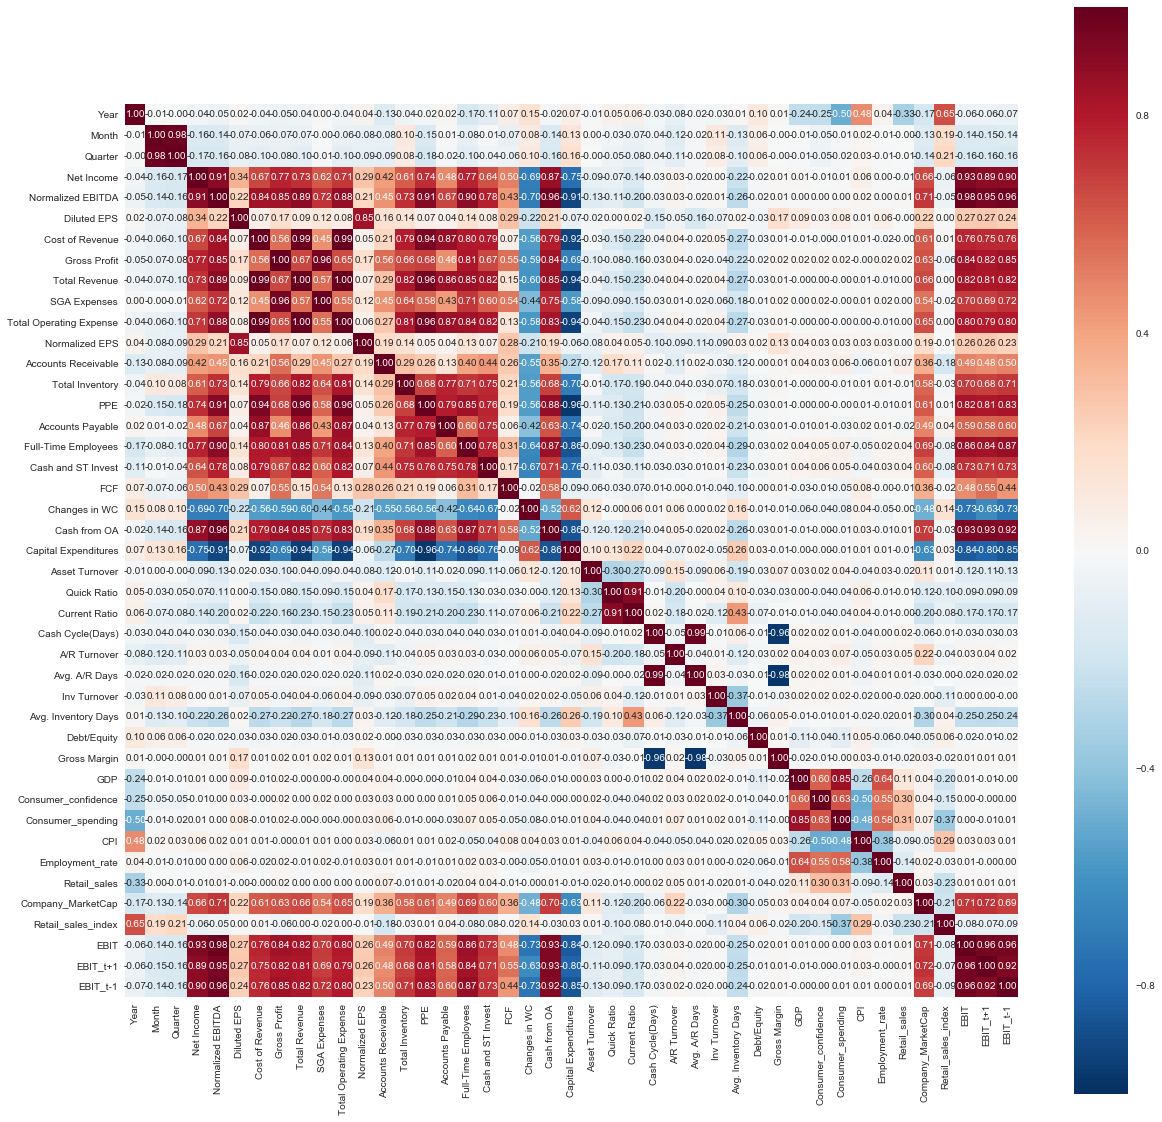

In [284]:
# plot a correlation matrix to idendify the important numeric features
numer = dfml.dropna().select_dtypes(include=['float64','int64']).columns
cm = np.corrcoef(dfml.dropna().select_dtypes(include=['float64','int64']).values.T)

sns.set(font_scale=1)

fig, ax = plt.subplots(figsize=(20, 20))

hm = sns.heatmap(cm,
                 cbar = True,
                 annot = True,
                 square = True,
                 fmt = '.2f',
                 annot_kws = {'size': 10},
                 ax = ax,
                 yticklabels= numer.values, xticklabels= numer.values)

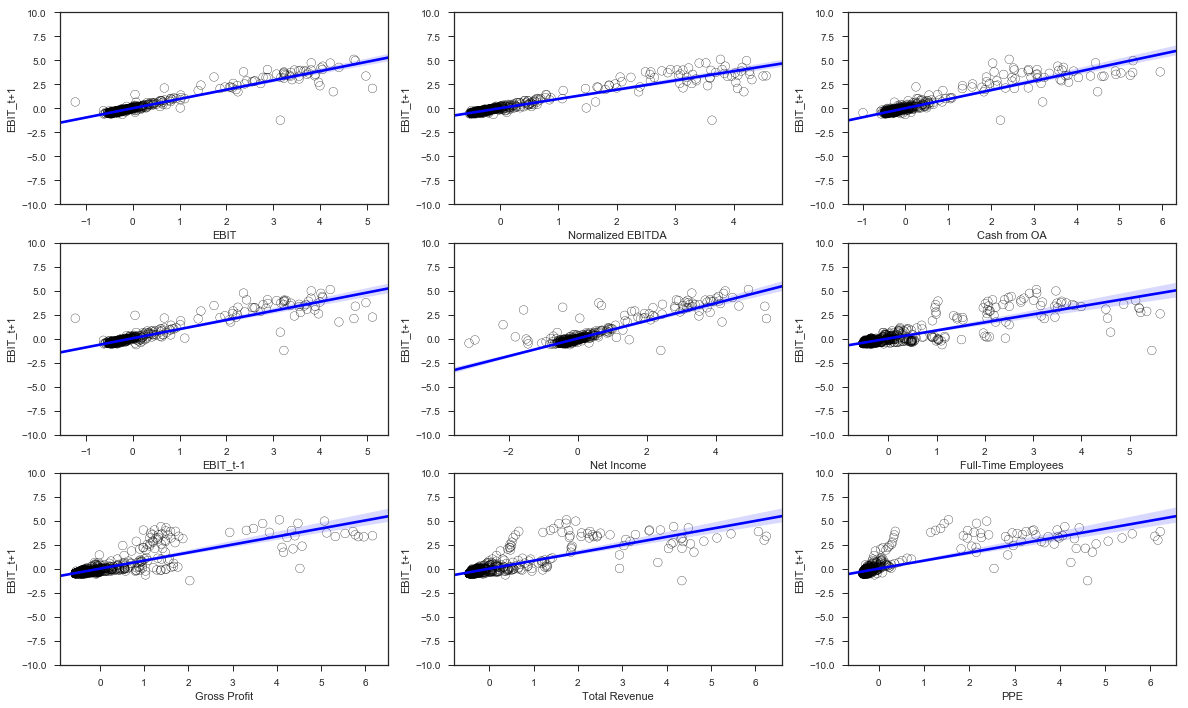

In [317]:
plt.figure(figsize=(20,12))
for i in range(9):
    ii = '33'+str(i+1)
    plt.subplot(ii)
    feature = corr_list.index.values[i]
    plt.scatter(dfml[feature], dfml['EBIT_t+1'], facecolors='none',edgecolors='k',s = 75)
    sns.regplot(x = feature, y = 'EBIT_t+1', data = dfml, scatter=False, color = 'Blue')
    ax=plt.gca() 
    ax.set_ylim([-10,10])

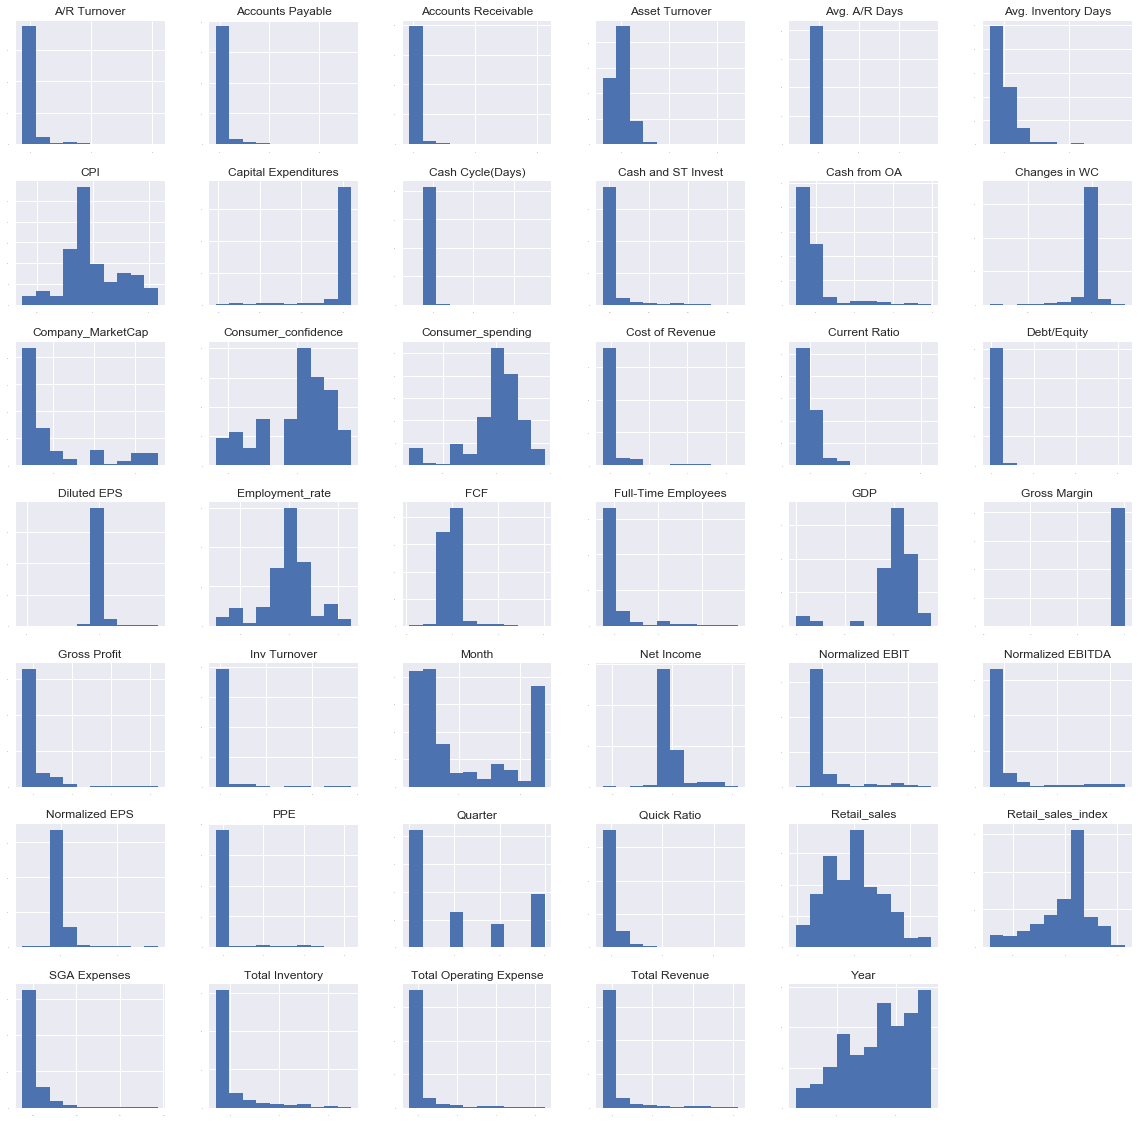

In [299]:
# histograms
plt.rcParams["figure.figsize"] = [20,20]
df1.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()

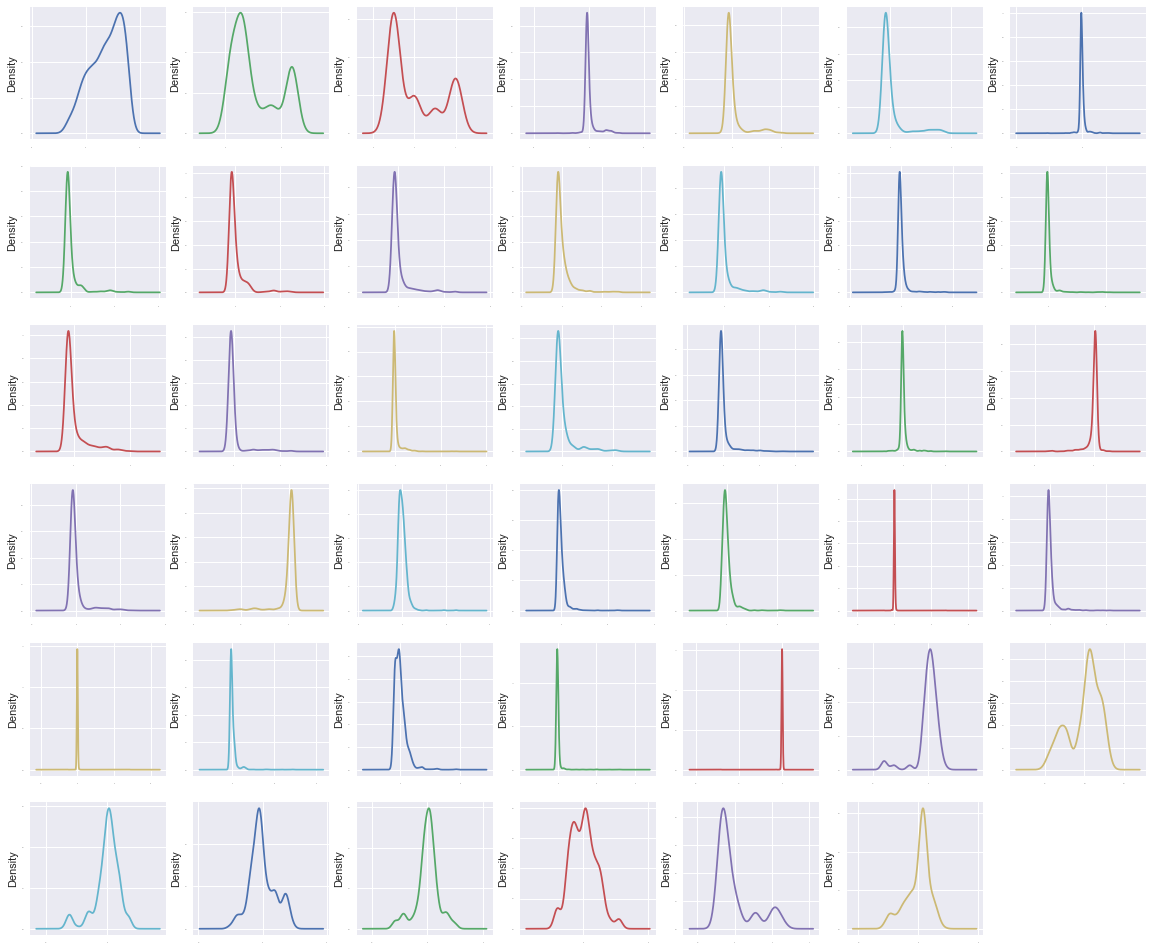

In [305]:
plt.rcParams["figure.figsize"] = [20,20]
df1.plot(kind='density', subplots=True, layout=(7,7), sharex=False, legend=False, fontsize=1)
plt.show()

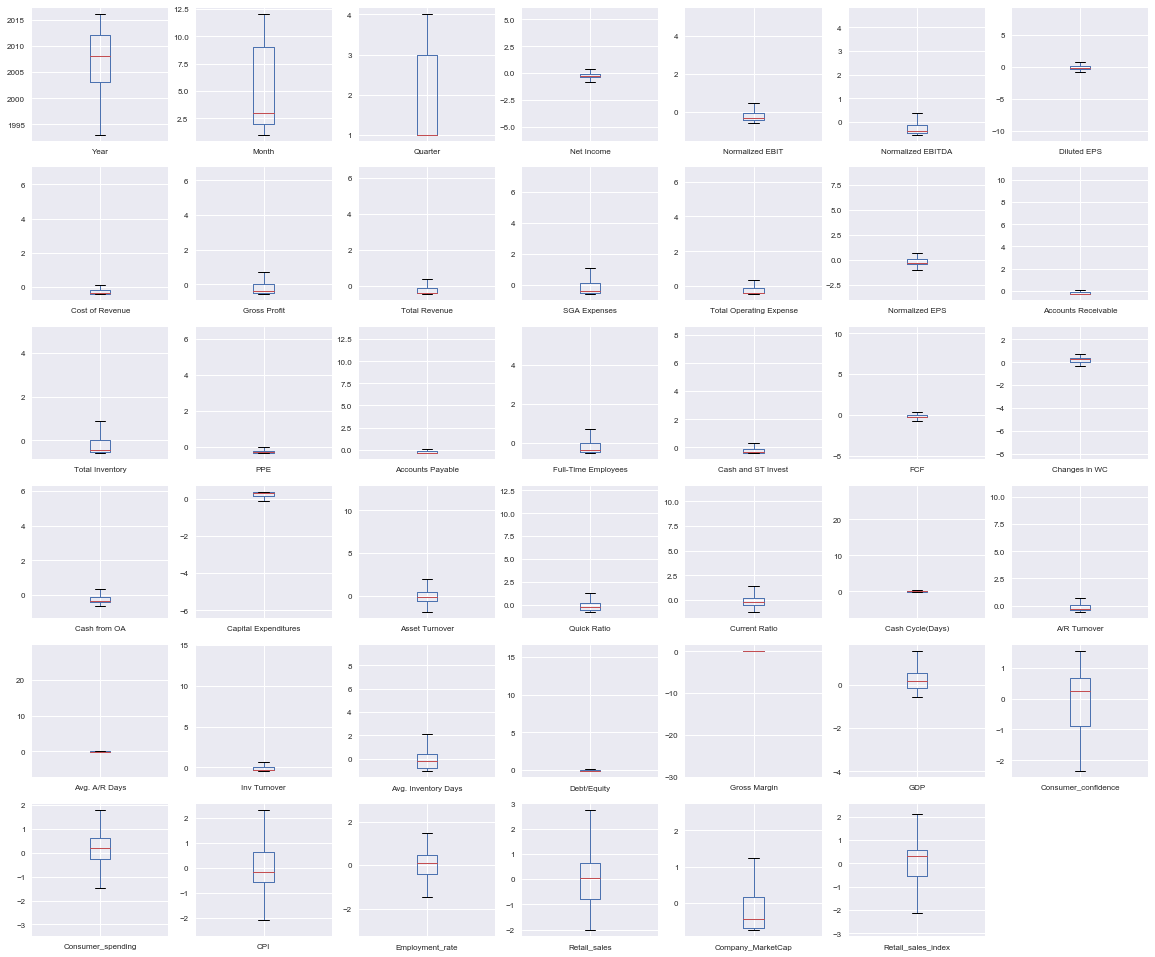

In [308]:
plt.rcParams["figure.figsize"] = [20,20]
df1.plot(kind='box', subplots=True, layout=(7,7), sharex=False, sharey=False, fontsize=8)
plt.show()

## EBIT t+1

In [103]:
# EBIT
dfml['EBIT_t+1'].describe()

count   759.000
mean      0.024
std       1.026
min      -1.230
25%      -0.449
50%      -0.357
75%      -0.080
max       5.117
Name: EBIT_t+1, dtype: float64

In [104]:
dfml.groupby(['Industry_group','Company_name'])['EBIT_t+1'].mean()

Industry_group                                 Company_name                   
Diversified Retail                             B&M European Value Retail SA       0.425
                                               Debenhams PLC                      0.388
                                               Findel PLC                        -0.281
                                               Ocado Group PLC                   -0.467
Food and Drug Retailing                        Booker Group PLC                  -0.180
                                               Conviviality PLC                     nan
                                               Crawshaw Group PLC                -0.476
                                               J Sainsbury PLC                    2.819
                                               Majestic Wine PLC                 -0.406
                                               McColl's Retail Group PLC         -0.352
                                         

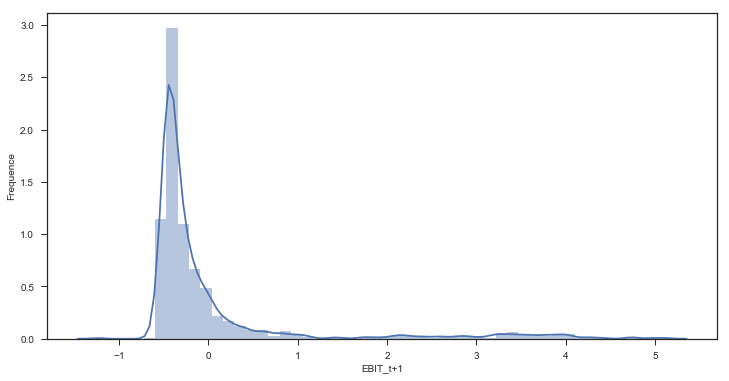

In [316]:
# distribution
plt.rcParams["figure.figsize"] = [12,6]
sns.distplot(dfml['EBIT_t+1'].dropna())
plt.ylabel('Frequence', fontsize=10, **csfont)
plt.xlabel("EBIT_t+1", fontsize=10, **csfont)

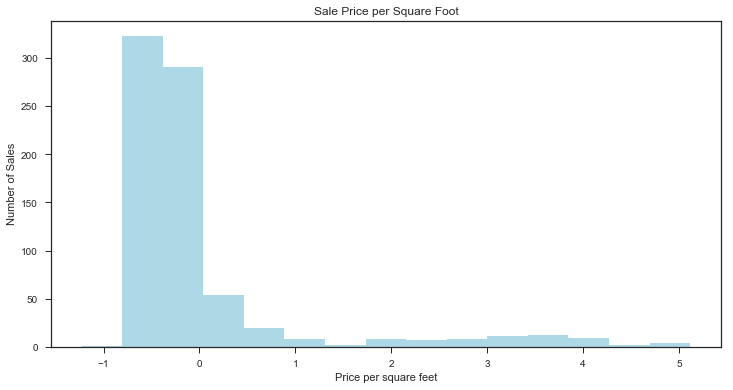

In [318]:
# hist
plt.hist(dfml['EBIT_t+1'].dropna(), bins=15,color="lightblue")
plt.title("Sale Price per Square Foot")
plt.ylabel('Number of Sales')
plt.xlabel('Price per square feet')

In [319]:
# skewness and kurtosis
print("Skewness: %f" % dfml['EBIT_t+1'].skew())
print("Kurtosis: %f" % dfml['EBIT_t+1'].kurt())

Skewness: 2.965641
Kurtosis: 8.160350


In [122]:
corr_list = corr['EBIT_t+1'].sort_values(axis=0,ascending=False).iloc[1:]
corr_list

EBIT                       0.958
EBITDA                     0.951
Cash from OA               0.933
EBIT_t-1                   0.924
Net Income                 0.893
Full-Time Employees        0.841
Gross Profit               0.820
Total Revenue              0.808
PPE                        0.807
Total Operating Expense    0.790
Cost of Revenue            0.749
Cash and ST Invest         0.715
Company_MarketCap          0.715
SGA Expenses               0.688
Total Inventory            0.681
Accounts Payable           0.579
FCF                        0.553
Accounts Receivable        0.479
Diluted EPS                0.264
EPS                        0.255
A/R Turnover               0.036
CPI                        0.022
Gross Margin               0.014
Retail_sales               0.009
Inv Turnover               0.008
Consumer_confidence        0.000
Employment_rate           -0.004
GDP                       -0.013
Consumer_spending         -0.014
Avg. A/R Days             -0.016
Debt/Equit

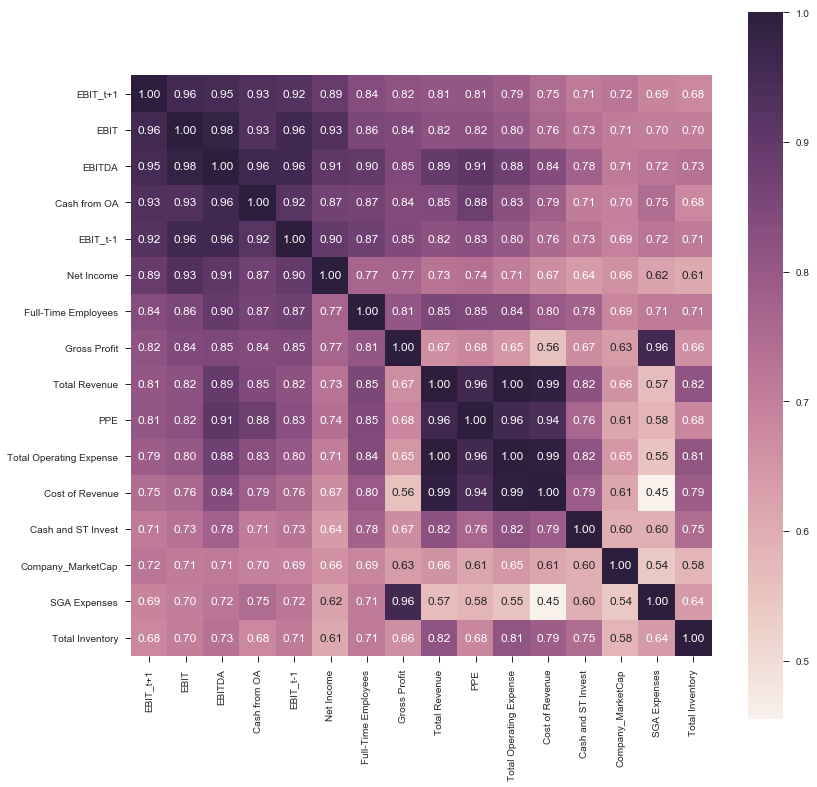

In [130]:
# EBIT t+1 correlation matrix
plt.figure(figsize = (13, 13))
k = 16 #number of variables for heatmap
cols = corr.nlargest(k, 'EBIT_t+1')['EBIT_t+1'].index
cm = np.corrcoef(dfml[cols].dropna().values.T)
#sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

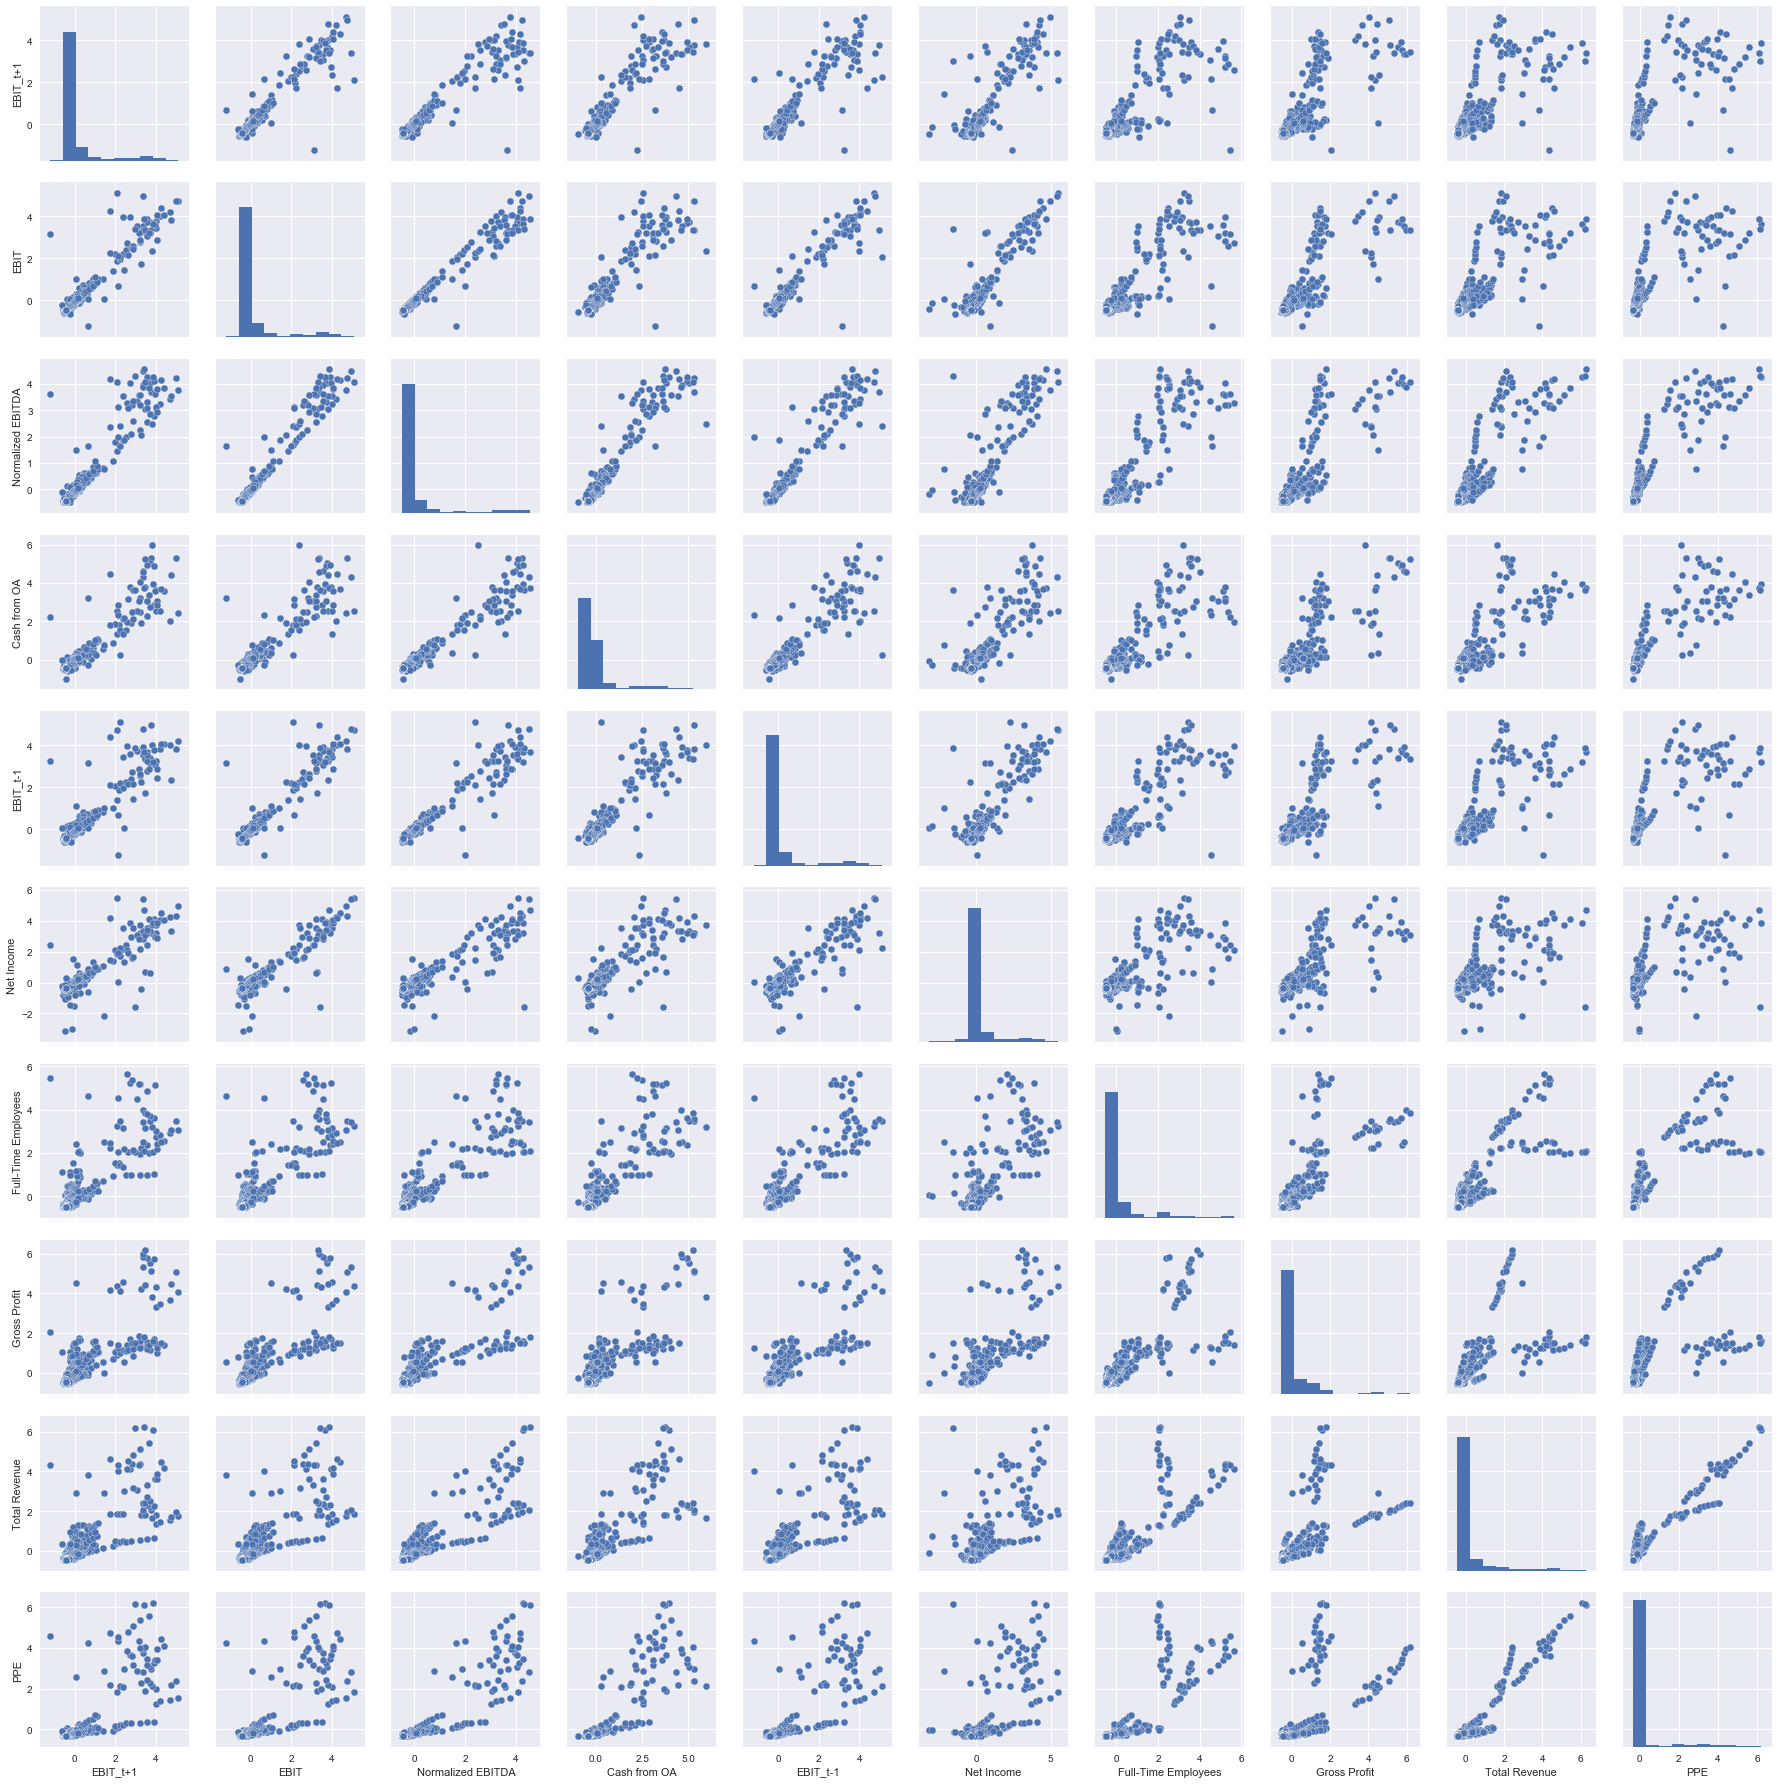

In [321]:
#scatterplot
sns.set()
cols = corr.nlargest(k, 'EBIT_t+1')['EBIT_t+1'].index
sns.pairplot(dfml[cols].dropna(), size = 2.5)
plt.show()

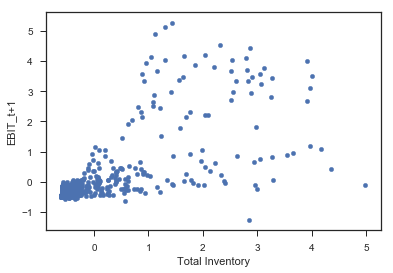

In [212]:
# scatter plot
var = 'Total Inventory'
data = pd.concat([dfml['EBIT_t+1'], dfml[var]], axis=1)
data.plot.scatter(x=var, y='EBIT_t+1') #,ylim=(-3,10), xlim=(-5,5)

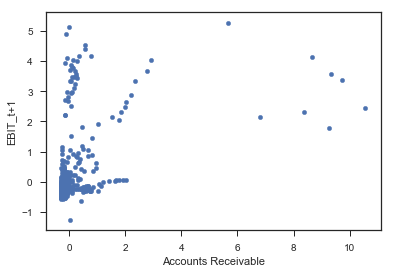

In [218]:
var = 'Accounts Receivable'
data = pd.concat([dfml['EBIT_t+1'], dfml[var]], axis=1)
data.plot.scatter(x=var, y='EBIT_t+1') 

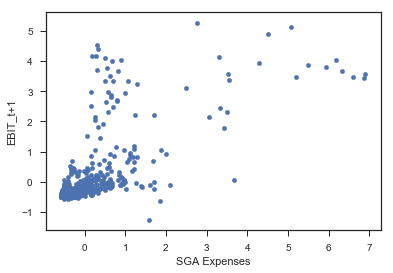

In [217]:
var = 'SGA Expenses'
data = pd.concat([dfml['EBIT_t+1'], dfml[var]], axis=1)
data.plot.scatter(x=var, y='EBIT_t+1') 

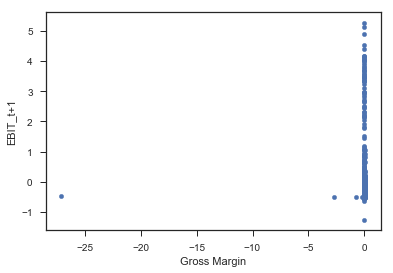

In [213]:
var = 'Gross Margin'
data = pd.concat([dfml['EBIT_t+1'], dfml[var]], axis=1)
data.plot.scatter(x=var, y='EBIT_t+1') 

In [323]:
dfmlna = dfml.dropna()

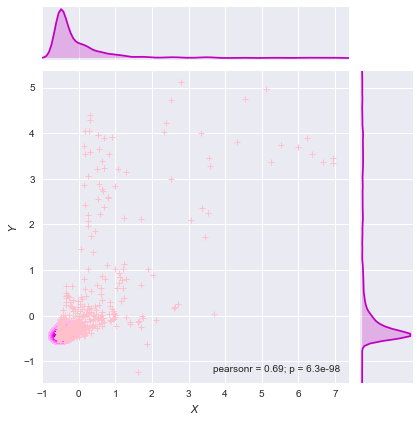

In [324]:
g = sns.jointplot(x="SGA Expenses", y="EBIT_t+1", data=dfmlna, kind="kde", color="m")
g.plot_joint(plt.scatter, c="pink", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")

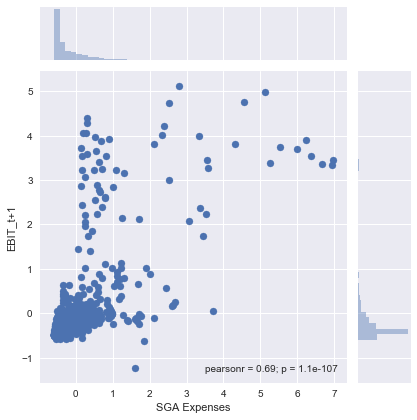

In [329]:
sns.jointplot(x="SGA Expenses", y='EBIT_t+1', data=dfml)
sns.set_style('ticks')

## Categorical Features

In [331]:
dfml.columns

Index(['Company_name', 'Year', 'Month', 'Quarter', 'Report_Date', 'Net Income',
       'Normalized EBITDA', 'Diluted EPS', 'Cost of Revenue', 'Gross Profit',
       'Total Revenue', 'SGA Expenses', 'Total Operating Expense',
       'Normalized EPS', 'Accounts Receivable', 'Total Inventory', 'PPE',
       'Accounts Payable', 'Full-Time Employees', 'Cash and ST Invest', 'FCF',
       'Changes in WC', 'Cash from OA', 'Capital Expenditures',
       'Asset Turnover', 'Quick Ratio', 'Current Ratio', 'Cash Cycle(Days)',
       'A/R Turnover', 'Avg. A/R Days', 'Inv Turnover', 'Avg. Inventory Days',
       'Debt/Equity', 'Gross Margin', 'Timestamp', 'GDP',
       'Consumer_confidence', 'Consumer_spending', 'CPI', 'Employment_rate',
       'Retail_sales', 'Retail_group', 'Business_sector', 'Industry_group',
       'Industry', 'Company_MarketCap', 'FY10', 'Retail_sales_index', 'EBIT',
       'EBIT_t+1', 'EBIT_t-1'],
      dtype='object')

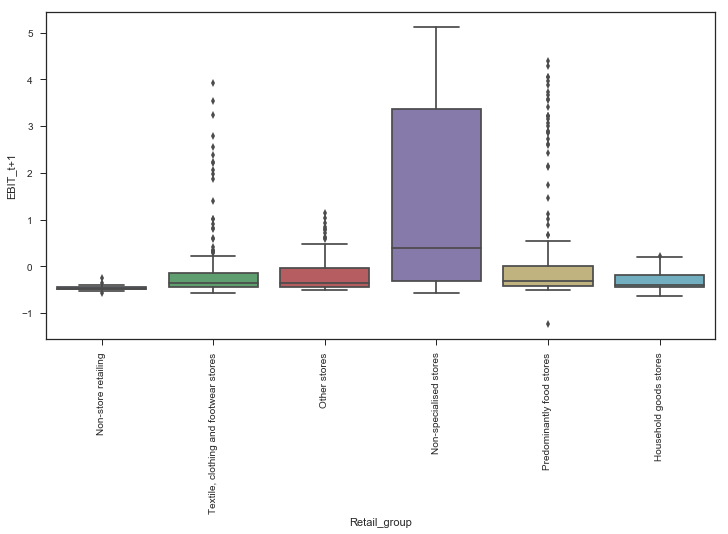

In [335]:
#Retail_group,Business_sector,Industry_group,Industry    
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Retail_group', y = 'EBIT_t+1', data = dfml)
xt = plt.xticks(rotation=90)

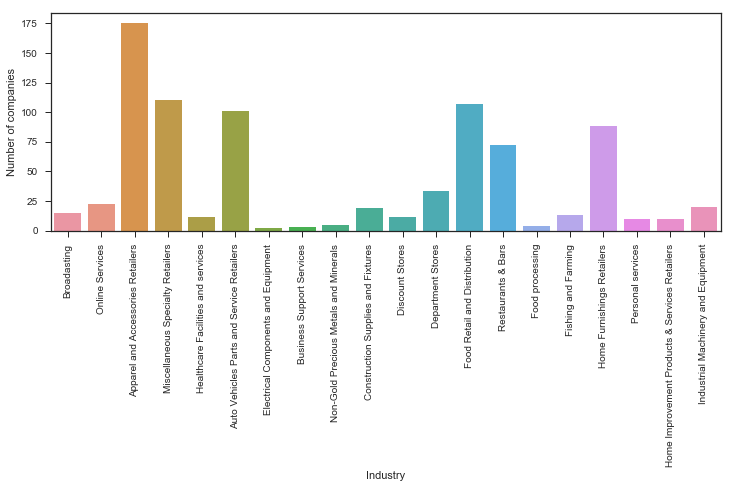

In [353]:
plt.figure(figsize = (12, 4))
sns.countplot(x = 'Industry', data = dfml)
plt.xlabel('Industry')
plt.ylabel('Number of companies')
xt = plt.xticks(rotation=90)

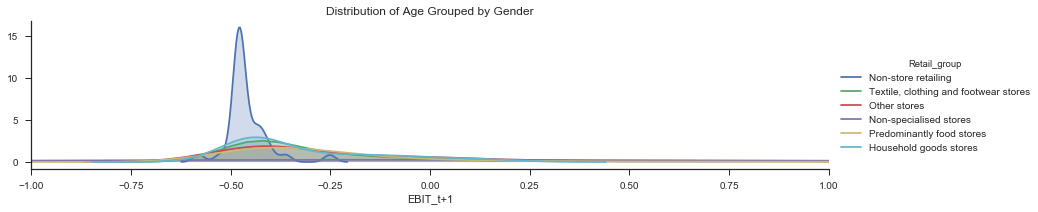

In [337]:
fig = sns.FacetGrid(dfml, hue='Retail_group', aspect=4)
fig.map(sns.kdeplot, 'EBIT_t+1', shade=True)
#oldest = dfml['Normalized EBIT'].max()
fig.set(xlim=(-1,1))
fig.set(title='Distribution of Age Grouped by Gender')
fig.add_legend()

# Save Dataframe

In [328]:
dfml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831 entries, 0 to 830
Data columns (total 51 columns):
Company_name               831 non-null object
Year                       831 non-null int64
Month                      831 non-null int64
Quarter                    831 non-null int64
Report_Date                831 non-null object
Net Income                 831 non-null float64
Normalized EBITDA          831 non-null float64
Diluted EPS                831 non-null float64
Cost of Revenue            831 non-null float64
Gross Profit               831 non-null float64
Total Revenue              831 non-null float64
SGA Expenses               831 non-null float64
Total Operating Expense    831 non-null float64
Normalized EPS             831 non-null float64
Accounts Receivable        831 non-null float64
Total Inventory            831 non-null float64
PPE                        831 non-null float64
Accounts Payable           831 non-null float64
Full-Time Employees        831 non-null

In [227]:
dfml.to_csv('Output/all_data_ml.csv', index=False, encoding='utf-8')

In [226]:
writer = ExcelWriter('Output/all_data_ml.xlsx')
dfml.to_excel(writer,'Sheet1')
writer.save()